# Importing

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import gurobipy as gp
from gurobipy import GRB
import math
from itertools import cycle
import tqdm

C:\Users\Cole\anaconda3\envs\generative_classifier\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_between(s, first, last):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

# Dataset

In [3]:
im_size = 14 # 28
image_width, image_height = im_size, im_size
window_size = 1
epsilon = 0.0001
variable_type = GRB.BINARY # GRB.CONTINUOUS, GRB.INTEGER, GRB.BINARY

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([ToTensor(), transforms.Resize([image_width, image_height])])
)

In [5]:
batch_size = 300 #30 # MUST BE EVENLY DIVISIBLE BY 10
thresh = torch.Tensor([0.3])

# not sure what "...and so on" implies, but define this list however you like
target_classes = [i // (batch_size / 10) for i in range(batch_size)]

# create cyclic iterators of indices for each class in MNIST
indices = dict()
for label in torch.unique(training_data.targets).tolist():
    indices[label] = cycle(torch.nonzero(training_data.targets == label).flatten().tolist())

# define the order of indices in the new mnist subset based on target_classes
new_indices = []
for t in target_classes:
    new_indices.append(next(indices[t]))

# create a Subset of MNIST based on new_indices
mnist_modified = torch.utils.data.Subset(training_data, new_indices)
dataloader = torch.utils.data.DataLoader(mnist_modified, batch_size=batch_size, shuffle=False)

for idx, (x, y) in enumerate(dataloader):
    # training loop
    print(f'Batch {idx+1} labels: {y.tolist()}')
    
dataset = next(enumerate(dataloader))[1]
print(dataset[1])
print(dataset[0][1, 0].shape)

Batch 1 labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

# L2 Distance

100%|██████████| 300/300 [00:01<00:00, 169.12it/s]


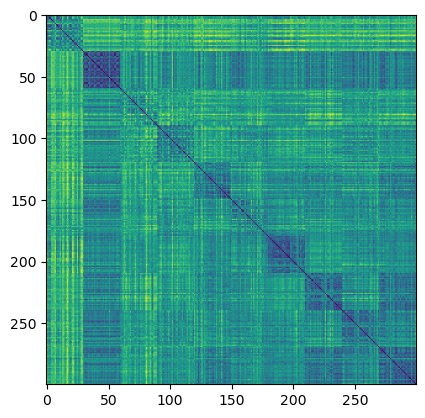

In [6]:
# Updated shift criss-cross constraints with binary images window=1
data_matrix = torch.zeros(batch_size, batch_size)

for i in tqdm.tqdm(range(len(dataset[1]))):
    im1 = (dataset[0][i, 0] > thresh).float() * 1
    
    for j in range(i + 1, len(dataset[1])):
        im2 = (dataset[0][j, 0] > thresh).float() * 1
        image_diff = torch.sum(torch.square(im1 - im2))
#         print(image_diff, flush=True)
        data_matrix[i, j] = image_diff
        data_matrix[j, i] = image_diff
        
#     if i % 10 == 0:
#         plt.figure(figsize=[3, 3])
#         plt.imshow(data_matrix)
#         plt.show()
        
plt.imshow(data_matrix)
plt.savefig("l2_similarity_matrix")
plt.show()

# Model

In [7]:
class MIP_Model:
    def __init__(self, image_width, image_height, window_size, shift_diff_window_size, variable_type, epsilon=0.01):
        self.epsilon = epsilon
        self.image_width = image_width
        self.image_height = image_height
        self.window_size = window_size
        self.shift_diff_window_size = shift_diff_window_size
        self.variable_type = variable_type
        
        self.m = gp.Model("image_similarity")
        self.m.Params.LogToConsole = 0
        self.m.setParam("Method", 3)

        # initialize pixel shift values
        self.image_shift_values = self.m.addVars(self.image_width, self.image_height, (2*self.window_size+1), (2*self.window_size+1), vtype=self.variable_type, lb=0, ub=1, name="shifts")

        # add constraints that if a pixel shift is outside image, it must be 0
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                for x_shift in range(2*self.window_size+1):
                    for y_shift in range(2*self.window_size+1):
                        if x_pixel + (x_shift - self.window_size) < 0 or x_pixel + (x_shift - self.window_size) > self.image_width-1 or y_pixel + (y_shift - self.window_size) < 0 or y_pixel + (y_shift - self.window_size) > self.image_height-1:
                            self.m.addConstr(self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] == 0)


        # constraints that all source pixels must shift in at least 1 direction
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                self.m.addConstr(gp.quicksum(self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1)) >= 1)

        # constraints that all dest pixels must be mapped to
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                self.m.addConstr(gp.quicksum(self.image_shift_values[x_pixel - (x_shift - self.window_size), y_pixel - (y_shift - self.window_size), x_shift, y_shift] \
                                        for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) \
                                        if x_pixel - (x_shift - self.window_size) >= 0 and x_pixel - (x_shift - self.window_size) < self.image_width and y_pixel - (y_shift - self.window_size) >= 0 and y_pixel - (y_shift - self.window_size) < self.image_height) \
                            >= 1)
    
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                for x_shift in range(2*self.window_size+1):
                    for y_shift in range(2*self.window_size+1):
                        self.add_no_part_constraint(x_pixel, y_pixel, x_shift, y_shift)
                        if y_pixel == 0 and x_pixel == 0:
                            continue
                        elif y_pixel == 0:
                            self.add_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                        elif x_pixel == 0:
                            self.add_down_constraint(x_pixel, y_pixel, x_shift, y_shift)
                        else:
                            self.add_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                            self.add_down_constraint(x_pixel, y_pixel, x_shift, y_shift)
                            self.add_down_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                        if y_pixel != self.image_height-1 and x_pixel != 0:
                            self.add_up_left_constraint(x_pixel, y_pixel, x_shift, y_shift)  

        self.initialize_model_values()
                
                
    def add_left_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        if x_shift != 2*self.window_size and x_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"amax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"amax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"amax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+2, 2*self.window_size+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)

    def add_down_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        if y_shift != 2*self.window_size and y_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"bmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"bmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"bmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel, y_pixel-1, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift+2, 2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)   
            
    def add_down_left_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        if x_shift != 2*self.window_size and x_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"cmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"cmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"cmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for xShifts in range(x_shift+2, 2*self.window_size+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)
        if y_shift != 2*self.window_size and y_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"dmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"dmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"dmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift+2, 2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)      
            
    def add_up_left_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        if x_shift != 2*self.window_size and x_shift != 2*self.window_size-1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"emax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"emax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"emax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel+1, xShifts, yShifts] for xShifts in range(x_shift+2, 2*self.window_size+1) for yShifts in range(2*self.window_size+1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)
        if y_shift != 0 and y_shift != 1: # left pixel can't be more right than curr pixel
            max1 = self.m.addVar(name=f"fmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max2 = self.m.addVar(name=f"fmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            max3 = self.m.addVar(name=f"fmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=self.variable_type)
            self.m.addConstr(max1 == gp.max_(self.image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift, 2*self.window_size+1)))
            self.m.addConstr(max2 == gp.max_(self.image_shift_values[x_pixel-1, y_pixel+1, xShifts, yShifts] for xShifts in range(2*self.window_size+1) for yShifts in range(y_shift-1)))
            self.m.addConstr(max3 == gp.max_(max1, max2))
            self.m.addConstr(max1 + max2 <= max3)
            
            
    def add_no_part_constraint(self, x_pixel, y_pixel, x_shift, y_shift):
        for x_neighbor in range(max(0, x_pixel-1), min(self.image_width, x_pixel+2)): 
            for y_neighbor in range(max(0, y_pixel-1), min(self.image_height, y_pixel+2)):
                if x_neighbor == x_pixel and y_neighbor == y_pixel:
                    continue
                sum_of_neighbor_pixel_shifts = gp.quicksum(self.image_shift_values[x_neighbor, y_neighbor, xShifts, yShifts] \
                                                                for xShifts in range(max(0, x_shift-1), min(2*self.window_size+1, x_shift+2)) for yShifts in range(max(0, y_shift-1), min(2*self.window_size+1, y_shift+2)))
        
        
                self.m.addConstr(self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] <= sum_of_neighbor_pixel_shifts)
            
            
            
    def initialize_model_values(self):
        for x_pixel in range(self.image_width):
            for y_pixel in range(self.image_height):
                for x_shift in range(2*self.window_size+1):
                    for y_shift in range(2*self.window_size+1):
                        if x_shift == self.window_size and y_shift == self.window_size:
                            self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift].start = 1
                        else:
                            self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift].start = 0
            
            
    def get_similarity(self, img1, img2, verbose=False):
        if verbose:
            self.m.Params.LogToConsole = 1
        else:
            self.m.Params.LogToConsole = 0

        # set objective function
#         self.m.setObjective(gp.quicksum(((img1[x_pixel, y_pixel] - img2[x_pixel + (x_shift - self.window_size), y_pixel + (y_shift - self.window_size)]).item() ** 2) * self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(self.image_width) for y_pixel in range(self.image_height) for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) if x_pixel + (x_shift - self.window_size) >= 0 and x_pixel + (x_shift - self.window_size) <= self.image_width-1 and y_pixel + (y_shift - self.window_size) >= 0 and y_pixel + (y_shift - self.window_size) <= self.image_height-1)\
#                        + (gp.quicksum(3*self.epsilon * self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(self.image_width) for y_pixel in range(self.image_height) for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) if x_shift - self.window_size != 0 or y_shift - self.window_size != 0)) \
#                        + (gp.quicksum(self.epsilon * self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(self.image_width) for y_pixel in range(self.image_height) for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) if x_shift - self.window_size == 0 and y_shift - self.window_size == 0)), GRB.MINIMIZE)
        
        self.m.setObjective(gp.quicksum(((img1[x_pixel, y_pixel] - img2[x_pixel + (x_shift - self.window_size), y_pixel + (y_shift - self.window_size)]).item() ** 2) * self.image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(self.image_width) for y_pixel in range(self.image_height) for x_shift in range(2*self.window_size+1) for y_shift in range(2*self.window_size+1) if x_pixel + (x_shift - self.window_size) >= 0 and x_pixel + (x_shift - self.window_size) <= self.image_width-1 and y_pixel + (y_shift - self.window_size) >= 0 and y_pixel + (y_shift - self.window_size) <= self.image_height-1)\
                       + (self.epsilon*gp.quicksum(self.image_shift_values)), GRB.MINIMIZE)
        
        self.m.optimize() 
        optimal_value = self.m.objVal

        return optimal_value
    
    
    def get_similarity_score(self, image1, image2, verbose=False):
        self.initialize_model_values()
        val1 = self.get_similarity(image1, image2, verbose)
        self.initialize_model_values()
        val2 = self.get_similarity(image2, image1, verbose)
    #     val2 = 0
        if verbose:
            print([val1, val2])
        return max(val1, val2)

In [8]:
model = MIP_Model(image_width, image_height, window_size, 1, variable_type)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-13


# Testing

2.0200000000000005
6.05
2.0600000000000005
2.0800000000000005
4.050000000000001
4.08
14.119999999999994
3.0700000000000003
2.0100000000000002
2.0300000000000007
2.0800000000000005
2.0300000000000002
11.09999999999999
2.1100000000000003
3.050000000000001
2.0400000000000005
4.190000000000001
2.0400000000000005
3.0500000000000007
2.990000000000001
2.1400000000000006
3.120000000000001
3.1300000000000012
3.060000000000001
4.1
10.069999999999997
6.029999999999998
11.139999999999999
3.130000000000001
25.049999999999983
29.989999999999984
31.979999999999983
32.97999999999998
25.059999999999988
16.06999999999999
30.019999999999985
22.04999999999999
25.069999999999986
23.989999999999984
32.98999999999998
24.049999999999986
27.059999999999988
26.049999999999983
31.969999999999985
30.97999999999998
24.05999999999998
32.01999999999998
23.039999999999985
33.989999999999974
28.019999999999982
36.99999999999998
25.049999999999986
29.029999999999983
26.039999999999985
32.97999999999998
30.0099999999999

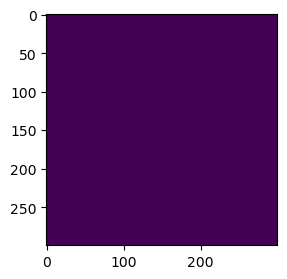

8.059999999999995
2.1000000000000005
3.0500000000000007
4.0600000000000005
3.0300000000000007
17.129999999999992
5.050000000000001
2.0400000000000005
2.0400000000000005
3.0700000000000007
3.0200000000000005
14.11999999999999
7.039999999999997
5.1000000000000005
1.9900000000000002
9.139999999999997
4.050000000000001
5.049999999999998
5.03
3.1600000000000006
7.1099999999999985
8.109999999999998
7.050000000000001
6.11
16.069999999999993
6.060000000000001
12.159999999999993
7.139999999999997
25.04999999999999
33.98999999999998
34.01999999999998
36.98999999999998
24.08999999999999
15.099999999999993
32.99999999999998
22.109999999999985
27.089999999999982
24.98999999999998
35.99999999999998
27.059999999999985
26.109999999999985
25.079999999999984
35.979999999999976
34.03999999999998
26.059999999999985
36.009999999999984
24.069999999999986
37.059999999999974
30.02999999999998
37.98999999999998
28.06999999999999
31.029999999999987
25.059999999999985
37.00999999999998
34.04999999999998
25.05999

15.129999876249991
9.069999999999993
17.069999999999993
16.09999999999999
17.03999999999999
8.040000000000001
16.099999999999987
21.07999999999999
10.089999999999995
11.059999999999993
15.089999999999986
11.059999999999995
11.019999999999996
10.059999999999999
7.079999999999998
8.089999999999996
15.01999999999999
14.089999999999996
11.039999999999996
20.089999999999986
13.089999999999993
14.059999999999992
23.089999999999982
7.989999999999997
12.08999999999999
11.069999999999997
12.039999999999994
11.11999999999999
8.040000000000003
11.129999999999997
13.099999999999998
11.039999999999994
7.010000000000002
6.010000000000002
6.040000000000002
6.040000000000001
9.029999999999998
9.020000000000001
7.000000000000001
9.05
12.029999999999994
7.050000000000002
9.07
8.030000000000001
7.989999999999999
7.9899999999999975
19.059999999999988
12.059999999999997
14.02999999999999
10.029999999999998
17.00999999999999
16.06999999999999
10.11999999999999
7.030000000000001
12.039999999999992
10.0199999

5.080000000000001
3.1400000000000006
3.1100000000000008
2.1100000000000003
4.060000000000001
5.199999999999999
5.1000000000000005
6.0600000000000005
14.169999999999991
4.150000000000001
12.139999999999993
6.129999999999999
35.05999999999999
41.00999999999998
42.00999999999998
44.989999999999974
32.11999999999998
23.16999999999999
40.069999999999986
31.119999999999983
36.09999999999998
31.029999999999976
45.019999999999975
33.05999999999999
36.079999999999984
37.069999999999986
43.979999999999976
42.04999999999998
34.11999999999998
45.02999999999999
32.09999999999999
46.999999999999986
37.08999999999998
38.049999999999976
37.059999999999974
40.03999999999998
33.10999999999998
45.009999999999984
42.02999999999999
33.10999999999998
29.119999999999983
39.06999999999998
16.159999999999993
15.13999999999999
12.039999999999992
24.03999999999998
24.099999999999987
12.07999999999999
33.07999999999999
19.01999999999999
18.069999999999986
27.129999999999985
23.099999999999987
22.039999999999996
1

21.139999999999986
16.15999999999999
12.059999999999999
26.019999999999985
6.019999999999998
13.09999999999999
22.04999999999999
17.069999999999993
22.07999999999999
19.07999999999999
17.17999999999999
22.139999999999986
19.19999999999999
20.139999999999986
26.13999999999998
17.19999999999999
14.179999999999989
16.18999999999999
19.18999999999999
14.159999999999997
16.149999999999995
16.209999999999994
12.139999999999993
18.109999999999992
23.189999999999984
33.09999999999999
18.18999999999999
15.17999999999999
20.219999999999985
16.169999999999984
30.159999999999982
14.209999999999992
15.099999999999994
14.199999999999989
16.079999999999995
32.089999999999975
16.179999999999996
24.12999999999998
25.099999999999987
22.099999999999987
23.13999999999998
25.049999999999986
28.079999999999984
28.12999999999998
29.10999999999998
16.089999999999993
25.05999999999999
26.049999999999986
27.079999999999984
23.04999999999999
27.049999999999983
17.10999999999999
25.03999999999999
25.0599999999999

4.100000000000001
26.019999999999985
13.059999999999997
3.0100000000000007
2.0900000000000003
36.96999999999998
39.98999999999998
38.969999999999985
39.95999999999999
35.96999999999998
30.069999999999983
37.96999999999998
34.969999999999985
35.97999999999998
32.99999999999998
34.96999999999998
34.009999999999984
35.97999999999998
32.95999999999998
38.969999999999985
38.98999999999998
34.979999999999976
33.969999999999985
34.98999999999998
35.96999999999998
34.97999999999998
40.979999999999976
32.969999999999985
33.969999999999985
35.98999999999998
37.969999999999985
38.979999999999976
36.95999999999999
32.99999999999998
35.969999999999985
31.059999999999985
24.079999999999988
19.079999999999988
27.089999999999986
18.009999999999987
24.089999999999986
30.099999999999984
21.119999999999983
20.079999999999988
26.029999999999983
23.089999999999993
23.069999999999983
17.07999999999999
22.11999999999999
26.009999999999984
29.009999999999987
22.099999999999984
23.08999999999998
24.09999999999

12.119999999999992
16.10999999999999
12.07
11.179999999999998
13.139999999999986
13.129999999999995
6.100000000000001
6.099999999999998
7.109999999999999
8.099999999999998
9.09
9.07
7.079999999999998
9.07
12.099999999999998
6.159999999999995
13.14999999999999
9.080000000000002
7.100000000000002
9.069999999999999
14.069999999999991
16.139999999999993
11.099999999999998
9.019999999999998
12.099999999999996
12.069999999999993
17.149999999999995
7.080000000000002
14.119999999999992
12.019999999999998
14.039999999999992
10.119999999999997
15.079999999999995
20.099999999999987
21.10999999999998
21.089999999999986
13.089999999999995
17.069999999999993
17.05999999999999
18.119999999999987
17.06999999999999
18.08999999999999
16.069999999999993
16.11999999999999
18.04999999999999
24.059999999999985
21.049999999999994
15.129999999999994
24.049999999999983
17.049999999999986
15.049999999999988
16.04999999999999
17.04999999999999
21.089999999999993
17.039999999999992
10.1
16.089999999999993
17.0699

29.02999999999998
27.059999999999985
20.07999999999999
16.079999999999995
25.099999999999984
8.14
12.069999999999993
10.0
22.009999999999984
17.079999999999988
10.039999999999996
26.009999999999984
13.99999999999999
20.029999999999987
17.099999999999987
17.119999908964797
16.04999999999999
9.009999999999998
14.019999999999994
8.08
22.079999999999984
9.019999999999998
13.069999999999993
15.009999999999991
20.069999999999986
20.06999999999999
22.04999999999998
16.019999999999992
22.029999999999987
16.049999999999994
11.049999999999999
25.10999999999998
17.03999999999999
18.00999999999999
14.04999999999999
7.009999999999998
13.06999999999999
18.06999999999998
12.039999999999994
28.069999999999983
22.01999999999999
6.049999999999998
12.129999999999994
13.06999999999999
28.049999999999986
15.039999999999992
10.009999999999996
11.079999999999995
16.06999999999999
11.03
19.039999999999992
15.00999999999999
8.040000000000001
12.009999999999994
12.02999999999999
20.08999999999998
10.01999999999

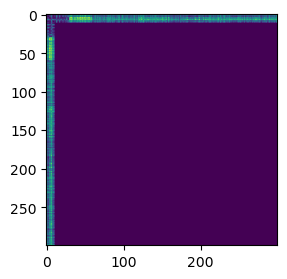

3.100000000000001
4.040000000000002
2.0300000000000002
3.1200000000000006
4.080000000000001
5.080000000000002
2.0400000000000005
3.160000000000001
6.069999999999999
2.0500000000000003
2.0300000000000002
4.150000000000001
2.1300000000000003
2.0300000000000007
13.179999999999989
8.069999999999999
4.149999999999997
2.0400000000000005
37.03999999999998
37.98999999999998
38.01999999999998
40.00999999999998
36.02999999999998
26.089999999999982
39.03999999999998
35.049999999999976
37.039999999999985
25.06999999999998
38.039999999999985
36.02999999999998
38.00999999999998
37.989999999999974
38.99999999999998
38.99999999999997
36.04999999999998
40.99999999999998
34.99999999999998
42.979999999999976
37.089999999999975
35.039999999999985
35.02999999999998
37.01999999999998
37.99999999999998
39.00999999999998
38.009999999999984
37.02999999999998
33.02999999999999
39.05999999999998
19.129999999999992
15.139999999999993
14.049999999999992
17.039999999999992
21.039999999999992
13.039999999999994
22.1

7.1599999999999975
16.03999999999999
12.10999999999999
12.04999999999999
12.079999999999995
12.129999999999992
9.019999999999996
17.059999999999985
12.989999999999995
14.019999999999992
12.099999999999993
15.069999999999997
12.13999999999999
10.09
13.139999999999993
16.099999999999987
19.04999999999999
9.1
8.089999999999996
5.110000000000001
6.139999999999999
6.119999999999997
9.059999999999999
8.079999999999998
8.080000000000002
16.04999999999999
6.139999999999999
16.129999999999992
7.100000000000001
8.079999999999997
9.09
17.069999999999986
18.139999999999986
12.079999999999998
9.029999999999992
14.069999999999995
11.049999999999994
19.12999999999998
6.090000000000001
14.099999999999989
15.97999999999999
14.029999999999992
10.129999999999994
12.079999999999991
17.149999999999995
20.099999999999987
22.099999999999987
14.049999999999995
12.11
13.089999999999995
18.08999999999999
14.059999999999993
17.07999999999999
13.049999999999994
13.089999999999996
15.05999999999999
24.079999999999

37.99999999999998
38.979999999999976
37.02999999999998
39.01999999999998
40.99999999999998
38.01999999999999
43.049999999999976
36.02999999999998
38.019999999999975
36.00999999999998
38.019999999999975
38.97999999999998
39.99999999999998
37.019999999999975
41.00999999999998
35.039999999999985
39.98999999999998
22.119999999999987
20.089999999999982
22.00999999999998
24.069999999999986
31.039999419583307
22.019999999999985
24.059999999999985
15.129999999999992
16.02999999999999
32.089999999999975
22.079999999999988
18.059999999999988
19.049999999999986
19.04999999999999
16.12999999999999
34.99999999999998
18.12999999999999
12.10999999999999
22.109999999999985
23.139999999999986
37.00999999999998
32.039999999999985
30.07999999999998
31.029999999999983
20.07999999999998
14.089999999999996
22.09999999999998
27.02999999999998
30.03999999999998
25.089999999999982
20.069999999999983
27.019999999999982
27.989999999999977
20.089999999999982
32.039999999999985
31.019999999999982
19.03999999999998

12.029999999999996
18.079999999999988
8.059999999999999
11.039999999999997
20.99999999999999
15.039999999999992
14.049999999999995
16.019999999999992
21.02999999999999
22.01999999999999
21.999999999999982
11.07
20.02999999999999
20.04999999999999
15.079999999999993
18.039999999999992
20.01999999999999
16.03999999999999
14.029999999999996
19.029999999999987
26.989999999999988
22.00999999999999
17.119999999999987
15.999999999999993
23.039999999999985
16.05999999999999
16.039999999999992
20.009999999999987
19.99999999999999
18.009999999999994
20.00999999999999
16.059999999999995
15.069999999999993
20.999999999999986
19.029999999999994
24.009999999999987
16.04999999999999
18.00999999999999
17.029999999999994
15.019999999999989
13.059999999999992
19.03999999999999
11.079999999999995
15.009999999999994
12.079999999999997
15.059999999999993
22.989999999999988
11.049999999999994
17.019999999999992
16.04999999999999
10.019999999999996
17.999999999999993
16.109999999999992
10.039999999999997
21.

23.049999999999986
31.089999999999975
27.03999999999998
16.159999999999993
14.13999999999999
31.109999999999978
24.099999999999984
25.099999999999984
22.089999999999982
27.089999999999975
32.049999999999976
31.009999999999977
26.05999999999998
40.099999999999966
37.00999999999998
26.039999999999978
31.089999999999975
30.049999999999983
39.059999999999974
30.049999999999983
29.049999999999983
21.119999999999987
35.04999999999998
33.02999999999998
32.049999999999976
27.00999999999998
30.07999999999998
21.079999999999984
21.149999999999984
29.03999999999998
23.119999999999983
19.13999999999999
27.99999999999998
34.049999999999976
27.02999999999998
23.019999999999982
33.07999999999998
21.119999999999994
30.02999999999998
36.059999999999974
35.13999999999997
37.03999999999997
38.07999999999998
45.07999999999997
36.04999999999998
25.059999999999985
43.119999999999976
16.179999999999996
28.199999999999985
34.09999999999997
31.16999999999998
35.14999999999998
31.20999999999998
34.1699999999999

23.009999999999987
24.999999999999986
21.03999999999999
20.059999999999985
23.019999999999985
26.98999999999998
30.97999999999998
21.00999999999998
26.039999999999985
21.049999999999983
27.01999999999998
24.049999999999986
14.039999999999992
34.019999999999975
22.049999999999994
19.039999999999985
24.009999999999984
24.98999999999998
20.039999999999985
18.01999999999999
22.059999999999988
27.039999999999985
22.03999999999998
24.079999999999988
22.08999999999999
21.019999999999985
26.04999999999999
25.03999999999999
25.079999999999984
21.099999999999987
24.019999999999985
22.07999999999999
25.989999999999984
21.03999999999999
20.099999999999987
15.039999999999988
18.07999999999999
25.029999999999987
24.049999999999986
27.039999999999985
27.019999999999985
20.069999999999986
28.01999999999998
16.109999999999992
26.029999999999987
21.03999999999999
31.009999999999984
20.08999999999999
19.04999999999999
25.019999999999985
24.05999999999998
23.039999999999985
28.019999999999985
24.009999999

18.05999999999999
15.109999999999992
22.109999999999985
16.009999999999994
15.109999999999996
15.009999999999993
12.119999999999996
20.009999999999984
11.079999999999998
10.079999999999998
14.109999999999992
15.009999999999987
10.059999999999997
10.069999999999999
15.139999999999995
21.049999999999983
27.049999999999983
19.079999999999984
16.009999999999987
22.069999999999983
21.039999999999992
25.04999999999999
11.019999999999996
20.069999999999983
26.05999999999999
18.10999999999999
8.049999999999997
18.109999999999985
13.049999999999992
19.02999999999999
13.04999999999999
11.039999999999997
9.14
14.06999999999999
14.089999999999987
13.039999999999985
12.089999999999993
14.13999999999999
12.019999999999994
13.04999999999999
13.039999999999996
13.01999999999999
13.07999999999999
14.079999999999991
8.12
9.059999999999999
10.129999999999988
12.099999999999994
19.049999999999986
11.069999999999997
11.069999999999995
7.069999999999998
8.139999999999997
8.069999999999997
7.0299999999999985

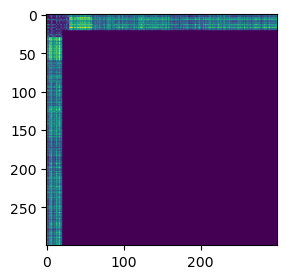

2.0100000000000002
5.160000000000001
8.16
2.0200000000000005
18.15999999999999
5.180000000000001
2.1000000000000005
2.0000000000000004
38.98999999999998
40.969999999999985
40.98999999999999
42.009999999999984
38.03999999999998
30.079999999999984
40.99999999999998
38.999999999999986
38.999999999999986
30.009999999999987
40.06999999999998
38.999999999999986
40.00999999999998
37.019999999999975
39.99999999999998
41.98999999999998
39.009999999999984
41.99999999999998
38.019999999999975
41.99999999999997
40.01999999999998
42.979999999999976
36.01999999999998
38.989999999999974
37.999999999999986
42.99999999999998
41.979999999999976
39.02999999999998
36.049999999999976
41.00999999999998
23.139999999999983
17.14999999999999
17.049999999999986
22.05999999999999
26.009999999999984
13.10999999999999
32.04999999999998
20.099999999999987
18.05999999999999
31.079999999999977
25.109999999999985
22.06999999999999
16.02999999999999
23.079999999999988
14.12999999999999
34.99999999999998
25.109999999999

11.199999999999998
20.209999999999983
15.179999999999989
20.12999999999999
28.15999999999998
34.07999999999998
15.199999999999989
16.219999999999988
22.239999999999977
21.099999999999987
32.12999999999998
14.219999999999992
10.149999999999997
14.150000000000002
8.099999999999998
39.02999999999998
10.249999999999993
33.06999999999998
30.079999999999977
17.189999999999984
29.149999999999977
25.10999999999999
35.10999999999998
27.12999999999998
35.05999999999999
17.119999999999994
29.109999999999985
32.06999999999999
27.039999999999985
26.079999999999984
31.099999999999984
20.12999999999999
22.099999999999994
24.099999999999987
31.029999999999987
36.079999999999984
25.14999999999998
24.03999999999999
30.04999999999999
21.119999999999983
22.099999999999987
28.059999999999985
32.05999999999998
21.049999999999994
25.12999999999999
22.13999999999999
20.11999999999999
28.059999999999988
22.09999999999999
29.079999999999995
20.13999999999999
29.079999999999984
29.019999999999982
26.109999999999

24.089999999999982
22.06999999999999
19.04999999999999
21.06999999999999
11.009999999999998
20.029999999999994
17.07999999999999
16.009999999999994
21.059999999999988
8.049999999999999
14.04999999999999
13.99999999999999
17.08999999999999
20.089999999999986
15.04999999999999
8.089999999999998
9.089999999999996
8.089999999999996
14.079999999999986
9.039999999999996
11.069999999999993
17.049999999999986
15.04999999999999
20.04999999999999
11.059999999999997
13.039999999999992
11.089999999999995
13.03999999999999
20.069999999999993
15.029999999999987
18.079999999999988
21.03999999999999
14.03999999999999
14.039999999999988
14.02999999999999
14.02999999999999
13.119999999999992
6.029999999999997
19.02999999999999
26.989999999999952
23.039999999999985
23.00999999999999
18.08999999999999
23.029999999999987
16.019999999999992
26.02999999999998
23.01999999999999
12.009999999999998
21.02999999999999
13.029999999999994
18.03999999999999
24.05999999999998
17.049999999999994
15.069999999999993
16.

25.009999999999984
27.059999999999985
30.05999999999998
21.03999999999999
30.039999999999985
28.069999999999986
18.079999999999988
34.009999999999984
21.089999999999982
22.019999999999985
27.079999999999988
25.069999999999986
28.04999999999999
20.029999999999987
30.02999999999998
30.04999999999998
19.079999999999988
27.049999999999986
20.079999999999984
29.039999999999985
25.029999999999987
29.079999999999984
31.03999999999998
28.039999999999992
28.039999999999985
25.02999999999999
27.049999999999983
28.059999999999985
23.079999999999988
10.149999999999997
25.039999999999992
25.03999999999999
26.049999999999986
29.069999999999986
29.03999999999998
24.03999999999999
26.049999999999986
23.06999999999999
23.039999999999985
27.029999999999987
30.089999999999986
25.079999999999984
26.049999999999983
25.04999999999999
29.079999999999984
27.05999999999999
24.03999999999999
26.059999999999988
26.079999999999988
29.029999999999983
6.07
26.019999999999982
23.069999999999986
18.01999999999999
15.

21.979999999999986
20.019999999999982
7.0199999999999925
20.059999999999988
24.009999999999987
15.139999999999986
6.0200000000000005
16.08999999999999
7.059999999999999
17.01999999999999
8.049999999999997
11.079999999999995
7.109999999999998
13.049999999999992
9.09
8.05
11.069999999999997
10.129999999999994
9.019999999999996
14.019999999999989
14.019999999999992
11.009999999999996
5.120000000000002
14.059999999999992
10.059999999999993
12.079999999999995
11.099999999999996
12.059999999999992
25.099999999999984
14.029999999999994
10.069999999999997
9.059999999999999
13.079999999999995
7.0899999999999945
9.03
12.039999999999996
10.049999999999994
13.029999999999996
12.129999999999997
21.059999999999988
12.039999999999996
10.049999999999992
16.039999999999985
17.01999999999999
23.029999999999987
10.059999999999999
10.0
11.029999999999996
13.019999999999994
23.08999999999999
11.039999999999997
13.07999999999999
22.989999999999984
15.989999999999993
17.04999999999999
14.059999999999995
22.0

19.119999999999987
18.01999999999999
21.07999999999999
22.999999999999986
17.039999999999992
28.099999999999984
15.109999999999985
13.069999999999993
27.01999999999999
19.14999999999999
16.08999999999999
18.029999999999987
16.089999999999993
20.089999999999986
30.999999999999982
18.10999999999999
17.13999999999999
18.13999999999999
23.12999999999999
27.029999999999987
23.079999999999988
27.099999999999987
23.019999999999982
19.079999999999988
11.159999999999993
25.099999999999987
20.07999999999999
24.019999999999982
22.159999999999986
22.049999999999986
30.00999999999998
27.02999999999998
23.099999999999987
27.119999999999983
29.009999999999984
23.01999999999999
25.089999999999982
29.999999999999982
31.039999999999978
28.009999999999984
27.02999999999998
24.019999999999982
27.039999999999985
30.02999999999998
27.049999999999983
20.019999999999982
26.049999999999983
20.029999999999987
24.01999999999999
23.019999999999982
22.029999999999983
21.029999999999987
23.009999999999984
33.039999

10.019999999999998
13.069999999999991
15.059999999999986
15.069999999999993
8.02
10.129999999999988
10.04
13.989999999999997
12.069999999999995
11.989999999999993
12.009999999999991
12.069999999999995
9.039999999999996
5.030000000000001
15.029999999999994
13.999999999999996
18.00999999999999
21.039999999999985
8.019999999999996
7.070000000000001
17.089999999999993
11.009999999999998
13.02999999999999
16.109999999999985
10.969999999999997
7.009999999999998
23.019999999999975
19.04999999999999
11.019999999999992
12.049999999999992
22.989999999999984
13.02999999999999
30.02999999999998
9.099999999999998
21.969999999999985
8.019999999999998
6.99
6.99
6.999999999999999
15.04999999999999
22.98999999999998
20.07999999999998
10.019999999999994
21.009999999999888
14.049999999999988
26.979999999999986
22.979999999999986
12.039999999999996
8.979999999999995
25.999999999999982
24.999999999999986
14.039999999999988
23.989999999999988
20.08999999999999
22.019999999999985
16.03999999999999
11.0199999

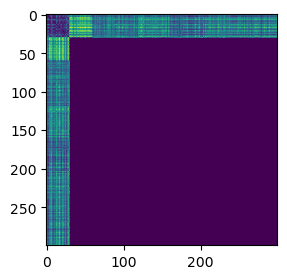

2.0200000000000005
2.0000000000000004
17.989999999999988
10.969999999999995
1.9800000000000004
16.95999999999999
10.989999999999998
6.02
2.0300000000000002
13.979999999999997
11.989999999999997
11.999999999999996
1.9700000000000002
2.0100000000000007
8.97
3.0500000000000007
12.979999999999999
6.02
1.9700000000000004
9.969999999999995
5.000000000000001
2.0000000000000004
10.990000000000002
2.0000000000000004
1.9600000000000004
17.98999999999999
16.959999999999994
1.9800000000000002
19.969999999999988
22.969999999999985
31.019999999999982
28.089999999999975
17.019999999999992
29.06999999999998
14.979999999999995
26.029999999999987
25.02999999999998
17.00999999999999
18.97999999999999
28.969999999999985
32.979999999999976
24.009999999999987
25.999999999999986
4.98
20.049999999999986
24.029999999999987
10.039999999999996
22.01999999999999
28.049999999999986
40.979999999999976
27.999999999999986
12.019999999999998
33.02999999999998
18.97999999999999
14.979999999999992
32.00999999999998
27.0

14.999999999999993
5.9899999999999975
21.009999999999987
17.00999999999999
18.009999999999987
13.989999999999986
17.999999999999993
10.019999999999992
18.999999999999982
16.979999999999986
21.979999999999986
8.959999999999997
18.96999999999999
12.009999999999993
33.95999999999999
12.059999999999995
22.98999999999998
21.999999999999986
21.05999999999998
5.969999999999997
21.009999999999984
16.03999999999999
15.969999999999992
20.009999999999984
10.009999999999994
19.009999999999987
12.999999999999988
19.029999999999987
15.059999999999993
20.04999999999999
15.069999999999991
14.029999999999994
20.089999999999982
16.99999999999999
17.00999999999999
19.059999999999985
14.069999999999997
13.049999999999995
18.97999999999999
22.04999999999999
10.040000000000003
26.03999999999998
15.019999999999996
17.04999999999999
21.059999999999988
6.059999999999998
16.05999999999999
22.109999999999992
13.999999999999993
9.030000000000001
20.069999999999986
28.09999999999998
16.99999999999999
15.0999999999

25.009999999999984
12.059999999999995
18.98999999999999
12.04999999999999
10.069999999999993
13.009999999999994
10.069999999999997
15.039999999999994
16.009999999999994
7.019999999999998
23.02999999999998
10.989999999999995
21.989999999999984
12.989999999999995
26.979999999999983
16.979999999999993
12.039999999999994
9.989999999999998
23.079999999999984
14.969999999999992
12.029999999999994
20.989999999999984
16.049999999999994
4.9999999999999964
7.979999999999999
10.079999999999991
5.9899999999999975
14.979999999999993
11.999999999999993
20.01999999999999
6.999999999999997
6.980000000000001
11.039999999999997
24.989999999999984
7.999999999999998
18.00999999999999
13.059999999999997
16.00999999999999
29.099999999999977
13.009999999999994
25.03999999999999
16.00999999999999
19.989999999999984
28.989999999999988
9.029999999999996
29.00999999999998
32.979999999999976
19.11999999999999
20.97999999999999
14.999999999999993
19.97999999999999
14.989999787043404
18.999999999999982
13.999999999

18.05999999999999
19.009999999999994
25.12999999999999
28.059999999999974
17.019999999999992
29.089999999999982
18.97999999999999
28.029999999999976
25.019999999999982
12.029999999999994
16.999999999999993
24.029999999999987
26.05999999999999
21.06999999999999
23.01999999999999
3.0000000000000004
21.059999999999988
24.059999999999985
15.009999999999994
20.979999999999986
25.059999999999988
33.02999999999999
22.059999999999988
15.999999999999993
33.059999999999974
18.97999999999999
14.969999999999995
32.03999999999998
26.069999999999986
29.039999999999978
22.04999999999999
11.049999999999997
24.019999999999982
29.099999999999987
16.99999999999999
12.959999999999996
18.039999999999996
13.029999999999994
15.009999999999993
21.989999999999995
15.029999999999992
18.069999999999993
36.05999999999998
9.01
17.059999999999988
13.979999999999993
24.059999999999985
18.089999999999993
26.019999999999982
20.999999999999986
20.98999999999999
21.029999999999987
19.97999999999999
20.069999999999993
20

11.049999999999994
10.059999999999993
10.119999999999996
8.049999999999997
4.050000000000001
14.989999999999988
15.019999999999985
17.999999999999986
23.03999999999998
8.029999999999994
6.130000000000001
16.139999999999993
10.999999999999993
11.069999999999993
14.179999999999971
8.979999999999995
6.029999999999999
21.00999999999998
19.079999999999988
12.059999999999992
9.09
19.069999999999986
12.009999999999994
27.009999999999984
9.129999999999994
19.979999999999997
7.019999999999999
6.989999999999996
5.030000000000001
5.999999999999998
16.04999999999999
20.979999999999986
22.069999999999983
10.019999999999992
18.999999999999986
13.059999999999995
23.979999999999986
20.98999999999999
9.059999999999997
6.999999999999998
24.979999999999983
22.99999999999999
14.019999999999996
21.96999999999999
19.069999999999993
21.00999999999999
17.02999999999999
8.079999999999993
23.999999999999986
12.99999999999999
14.99999999999999
25.979999999999983
15.009999999999993
12.029999999999994
25.979999999

12.019999999999994
14.019999999999989
11.009999999999996
11.009999999999991
3.990000000000001
11.989999999999995
9.019999999999998
12.98999999999999
9.999999999999996
12.059999999999992
13.999999999999993
10.01
10.979999999999995
10.999999999999995
7.999999999999998
6.969999999999995
11.989999999999998
13.009999999999994
9.03
9.04
8.999999999999996
12.989999999999997
13.999999999999991
12.009999999999994
18.01999999999999
10.989999999999997
12.009999999999994
13.009999999999994
10.069999999999999
14.989999999999993
9.979999999999992
19.97999999999999
17.99999999999999
14.009999999999993
11.019999999999994
17.04999999999999
18.029999999999987
18.989999999999988
16.02999999999999
19.029999999999987
14.019999999999994
21.019999999999985
18.00999999999999
19.999999999999993
12.009999999999998
20.979999999999986
14.009999999999993
29.00999999999998
8.979999999999997
18.01999999999999
21.029999999999983
22.989999999999984
10.019999999999996
18.99999999999999
16.99999999999999
15.999999999999

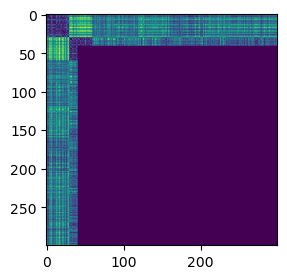

1.9900000000000004
1.9800000000000004
7.979999999999996
16.959999999999994
1.9900000000000004
7.01
2.0200000000000005
5.010000000000002
5.98
26.969999999999978
4.960000000000001
5.98
2.0200000000000005
9.96
12.969999999999997
1.9900000000000002
1.9900000000000002
4.970000000000001
19.00999999999999
19.01999999999999
25.029999999999987
32.02999999999997
20.97999999999999
30.049999999999983
19.999999999999986
22.08999999999999
28.049999999999983
13.009999999999996
18.96999999999999
20.069999999999986
24.019999999999985
19.079999999999995
19.03999999999999
8.989999999999998
18.089999999999993
20.07999999999999
17.029999999999994
18.00999999999999
21.06999999999999
33.02999999999998
17.049999999999986
17.989999999999988
32.02999999999997
20.019999999999992
15.979999999999992
28.04999999999998
24.079999999999977
24.049999999999986
21.109999999999985
13.049999999999997
25.979999999999983
28.10999999999998
20.999999999999993
17.989999999999988
17.05999999999999
14.979999999999995
19.009999999

8.030000000000001
11.129999999999995
10.089999999999996
12.019999999999998
10.109999999999994
11.059999999999999
11.009999999999993
11.119999999999994
7.059999999999999
3.060000000000001
14.999999999999991
14.079999999999991
12.989999999999991
20.009999999999987
9.019999999999998
8.109999999999998
15.089999999999991
6.0200000000000005
11.08999999999999
13.149999999999991
9.02
5.04
18.03999999999999
22.059999999999985
13.059999999999992
8.120000000000001
21.079999999999984
7.999999999999998
28.98999999999998
12.129999999999992
18.969999999999995
5.98
6.979999999999997
5.000000000000001
5.970000000000001
13.019999999999998
17.989999999999984
19.039999999999985
7.990000000000001
21.009999999999987
12.999999999999996
22.96999999999999
17.98999999999999
5.980000000000001
5.9700000000000015
21.989999999999988
17.989999999999995
12.019999999999998
18.989999999999988
19.04999999999999
17.99999999999999
12.009999999999994
7.999999999999997
18.999999999999993
9.979999999999995
11.009999999999993

19.959999999999983
9.999999999999996
15.989999999999991
17.00999999999999
12.969999999999994
12.999999999999993
8.06
17.02999999999999
15.989999999999995
18.96999999999999
12.989999999999995
19.95999999999999
20.98999999999999
16.069999999999993
19.039999999999992
17.009999999999987
12.029999999999996
8.019999999999998
17.98999999999999
18.009999999999987
15.039999999999992
16.00999999999999
8.979999999999997
17.97999999999999
22.029999999999987
19.969999999999988
28.969999999999985
7.020000000000001
18.98999999999999
16.98999999999999
16.119999999999994
20.039999999999985
13.019999999999994
19.96999999999998
13.989999999999993
16.99999999999999
8.009999999999998
23.019999999999982
17.969999999999988
17.969999999999988
16.009999999999984
20.96999999999998
12.989999999999993
22.979999999999983
17.969999999999988
21.96999999999998
8.969999999999999
17.969999999999985
11.969999999999994
38.95999999999998
8.050000000000002
22.979999999999983
23.95999999999998
29.019999999999982
5.980000000

31.959999999999987
13.979999999999992
24.979999999999986
11.039999999999996
2.9800000000000004
20.019999999999992
31.999999999999982
3.0100000000000007
30.999999999999986
19.029999999999987
20.979999999999997
15.039999999999988
16.039999999999985
15.01999999999999
9.049999999999997
15.999999999999986
11.979999999999997
7.999999999999998
26.999999999999986
9.029999999999994
25.969999999999985
10.059999999999999
31.96999999999998
15.04999999999999
13.059999999999995
7.03
23.079999999999984
17.049999999999994
10.069999999999993
13.979999999999993
17.01999999999999
9.009999999999996
9.99
13.019999999999992
10.989999999999995
11.969999999999995
6.989999999999996
16.019999999999992
11.979999999999997
9.979999999999997
16.00999999999999
21.99999999999999
12.979999999999993
16.029999999999987
13.049999999999994
16.999999999999993
25.08999999999999
13.009999999999991
23.02999999999999
15.999999999999991
14.029999999999996
26.019999999999985
9.989999999999998
26.999999999999982
26.95999999999998

16.99999999999999
21.019999999999985
16.02999999999999
18.039999999999985
6.0
14.039999999999996
18.039999999999992
12.039999999999994
13.969999999999992
14.059999999999992
28.049999999999972
10.129999999999999
14.989999999999998
25.109999999999985
18.029999999999994
13.009999999999991
23.08999999999999
16.089999999999993
19.049999999999986
16.08999999999999
9.04
24.98999999999999
21.11999999999999
21.969999999999988
19.98999999999999
13.079999999999997
13.989999999999995
16.98999999999999
27.979999999999983
16.999999999999996
13.069999999999993
31.079999999999988
10.989999999999998
13.079999999999995
16.989999999999995
23.039999999999985
13.099999999999996
22.059999999999985
19.04999999999999
19.999999999999982
19.04999999999999
16.00999999999999
14.069999999999995
29.979999999999983
14.059999999999993
21.049999999999986
21.989999999999984
17.97999999999999
12.079999999999995
30.959999999999987
14.029999999999992
21.97999999999999
16.009999999999994
3.0200000000000005
22.9899999999999

17.019999999999992
10.009999999999998
9.0
14.999999999999996
8.03
18.029999999999987
13.989999999999997
18.04999999999999
11.02999999999999
26.989999999999984
20.029999999999987
25.989999999999984
18.01999999999999
10.019999999999996
8.029999999999996
19.989999999999984
17.029999999999987
19.04999999999999
16.999999999999993
24.02999999999998
14.029999999999998
14.009999999999991
14.04999999999999
17.009999999999987
11.019999999999992
11.019999999999989
21.979999999999986
13.009999999999993
12.029999999999996
20.959999999999994
18.97999999999999
2.0000000000000004
3.000000000000001
2.9800000000000004
3.0000000000000004
1.9700000000000002
8.979999999999999
6.970000000000001
1.9900000000000004
19.99999999999999
18.97999999999999
23.09999999999999
25.049999999999976
15.009999999999994
27.079999999999984
18.00999999999999
23.03999999999998
23.009999999999987
8.02
14.97999999999999
22.98999999999998
27.019999999999985
19.00999999999999
24.969999999999978
1.9800000000000004
16.06999999999999

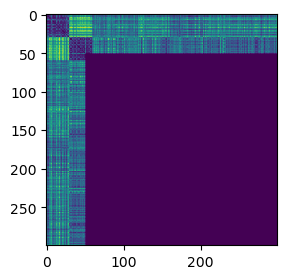

23.969999999999985
23.969999999999988
27.97999999999998
12.959999999999997
8.96
28.97999999999998
28.969999999999985
20.969999999999988
24.01999999999999
28.019999999999982
28.999999999999982
23.069999999999986
19.00999999999999
29.089999999999982
15.989999999999991
24.029999999999987
22.029999999999987
28.969999999999978
20.97999999999999
29.01999999999999
34.99999999999998
23.029999999999987
36.979999999999976
19.979999999999983
25.00999999999998
26.009999999999987
25.979999999999983
23.989999999999988
30.019999999999975
38.02999999999997
36.99999999999998
16.01999999999999
35.99999999999998
24.98999999999998
19.96999999999999
34.97999999999997
29.00999999999998
37.979999999999976
25.009999999999984
18.009999999999994
12.02
26.029999999999983
10.05
6.989999999999999
20.999999999999986
16.029999999999994
8.01
7.990000000000001
10.979999999999995
28.009999999999984
27.04999999999999
11.99
26.979999999999986
11.039999999999988
21.02999999999999
29.979999999999976
23.009999999999987
27.9

10.099999999999993
5.100000000000001
13.999999999999995
16.07999999999999
10.999999999999996
21.099999999999987
9.049999999999995
12.089999999999993
20.029999999999987
7.0200000000000005
13.099999999999996
20.069999999999986
9.02
4.050000000000001
15.069999999999991
20.159999999999982
14.019999999999989
9.129999999999999
21.09999999999999
6.11
25.009999999999984
17.049999999999986
15.009999999999994
6.030000000000001
8.009999999999996
9.979999999999997
5.980000000000001
13.039999999999994
8.999999999999996
16.98999999999999
8.029999999999998
22.999999999999986
15.019999999999989
23.01999999999999
15.019999999999992
6.019999999999998
6.010000000000001
20.029999999999987
14.029999999999994
14.00999999999999
13.039999999999996
23.029999999999983
10.049999999999999
11.989999999999991
10.009999999999998
13.039999999999994
7.019999999999997
10.989999999999991
24.979999999999986
9.029999999999992
9.989999999999997
23.989999999999988
4.0200000000000005
2.9800000000000004
2.9900000000000007
7.9

18.069999999999993
24.009999999999987
9.079999999999997
10.99999999999999
6.979999999999999
17.999999999999993
8.02
21.059999999999988
11.969999999999995
7.979999999999998
14.029999999999994
15.989999999999988
8.999999999999993
17.04999999999999
10.039999999999996
13.989999999999991
8.029999999999992
5.979999999999998
9.979999999999993
36.969999999999985
7.0100000000000025
15.00999999999999
17.009999999999987
31.019999999999982
16.989999999999995
29.049999999999983
11.019999999999992
6.999999999999997
15.049999999999985
6.009999999999998
12.02999999999999
12.029999999999998
14.019999999999992
7.010000000000001
9.119999999999992
9.049999999999999
10.989999999999998
9.090000000000002
10.079999999999997
11.019999999999996
11.069999999999997
6.050000000000001
3.030000000000001
15.009999999999991
15.019999999999992
13.989999999999993
21.99999999999999
7.9999999999999964
8.079999999999997
15.069999999999993
6.0
11.049999999999992
12.169999999999995
9.989999999999995
5.01
18.009999999999987
2

15.989999999999991
19.02999999999999
18.969999999999576
13.999999999999991
27.989999995569953
17.969999999999988
28.009999999999987
22.979999999999986
16.06999999999999
16.979999999999993
17.96999999999999
7.000000000000001
13.979999999999995
16.01999999999999
12.009999999999994
12.989999999999995
4.090000000000001
13.059999999999995
13.059999999999992
17.97999999999999
12.059999999999993
19.979999999999986
20.03999999999999
16.05999999999999
17.02999999999999
14.049999999999992
11.049999999999995
6.029999999999995
16.00999999999999
17.019999999999996
14.059999999999992
15.019999999999992
6.0
16.999999999999993
21.049999999999986
18.00999999999999
26.979999999999983
7.970000000000001
16.989999999999988
11.989999999999997
13.139999999999993
20.039999999999985
11.04
21.959999999999987
16.96999999999999
13.969999999999992
9.969999999999995
21.009999999999984
20.969999999999985
19.969999999999988
15.989999999999991
19.969999999999988
12.979999999999992
19.979999999999983
18.979999999999986

11.079999999999995
17.029999999999994
15.98999999999999
7.039999999999997
24.009999999999987
11.049999999999994
25.969999999999985
14.999999999999996
26.969999999999985
18.999999999999993
14.069999999999993
10.999999999999998
26.07999999999998
16.98999999999999
14.019999999999992
18.969999999999988
15.00999999999999
7.020000000000001
9.979999999999997
13.01999999999999
7.9899999999999975
13.969999999999994
9.979999999999993
15.009999999999993
9.969999999999995
7.989999999999996
14.009999999999998
21.96999999999999
10.999999999999995
16.039999999999992
13.059999999999995
15.009999999999991
27.109999999999985
12.989999999999993
24.029999999999987
13.009999999999994
15.999999999999993
24.99999999999999
9.979999999999997
25.039999999999985
29.97999999999998
17.109999999999992
19.01999999999999
14.999999999999991
17.989999999999988
14.969999999999994
18.019999999999992
11.019999999999996
18.009999999999984
17.019999999999992
20.099999999999987
13.01999999999999
14.009999999999994
13.0099999

16.999999999999996
20.05999999999999
5.1000000000000005
11.049999999999994
12.079999999999997
14.029999999999989
11.109999999999998
9.019999999999994
9.09
22.05999999999999
8.1
9.179999999999996
12.009999999999994
13.029999999999996
8.079999999999998
29.979999999999983
10.019999999999998
21.009999999999984
16.99999999999999
16.009999999999994
22.02999999999999
22.029999999999987
14.999999999999993
13.059999999999995
14.019999999999996
15.999999999999995
13.009999999999996
14.999999999999995
8.999999999999998
8.989999999999998
11.049999999999997
8.999999999999996
11.039999999999996
18.079999999999988
8.999999999999996
16.039999999999996
11.03
16.049999999999994
16.999999999999993
10.999999999999996
10.009999999999998
18.049999999999994
9.02
12.019999999999994
7.040000000000001
14.029999999999994
16.04999999999999
10.039999999999997
11.999999999999991
17.00999999999999
17.029999999999994
13.019999999999996
7.029999999999998
14.09999999999999
11.089999999999991
10.039999999999997
12.01999

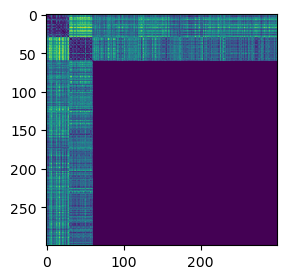

13.089999999999995
21.019999999999992
19.02999999999999
6.130000000000001
14.029999999999994
10.099999999999996
12.049999999999995
12.969999999999999
9.069999999999999
7.02
17.099999999999987
8.049999999999999
11.039999999999994
13.999999999999995
15.069999999999991
13.039999999999994
10.019999999999998
4.010000000000001
10.04
22.04999999999999
10.029999999999994
12.009999999999998
11.039999999999992
17.00999999999999
11.079999999999995
8.08
10.029999999999994
12.039999999999996
9.099999999999998
9.989999999999995
17.029999999999987
11.179999999999998
21.009999999999987
17.02999999999999
12.049999999999995
13.009999999999991
13.049999999999994
28.02999999999999
13.039999999999992
8.06
17.19999999999999
10.989999999999991
12.069999999999995
19.00999999999999
14.119999999999994
10.069999999999995
14.059999999999993
10.039999999999996
11.049999999999997
13.04999999999999
7.999999999999996
9.089999999999998
27.029999999999987
10.04
8.119999999999997
18.049999999999986
13.019999999999994
13

4.1000000000000005
16.07999999999999
17.069999999999997
16.079999999999995
21.09999999999999
18.089999999999996
21.049999999999986
19.02999999999999
16.09999999999999
15.099999999999994
26.03999999999999
24.06999999999999
17.099999999999994
15.079999999999997
19.069999999999993
16.109999999999996
18.09999999999999
19.08999999999999
15.099999999999994
21.129999999999985
29.03999999999999
10.039999999999996
12.019999999999998
27.03999999999999
19.08
8.01
21.01999999999999
19.07999999999999
16.079999999999995
20.099999999999987
13.079999999999998
29.049999999999976
21.069999999999983
23.029999999999994
25.049999999999986
27.02999999999998
22.05999999999999
25.02999999999998
9.04
29.019999999999982
15.049999999999997
24.039999999999992
32.03999999999998
18.07999999999999
24.049999999999986
18.049999999999997
27.029999999999983
19.02999999999999
19.039999999999992
16.999999999999993
14.069999999999995
17.10999999999999
17.08
19.03999999999999
21.08999999999999
18.05999999999999
22.049999999

19.979999999999986
16.999999999999993
14.029999999999996
12.069999999999995
18.01999999999999
15.009999999999993
14.029999999999994
13.999999999999993
12.019999999999996
19.009999999999984
13.029999999999994
11.029999999999998
14.989999999999993
10.030000000000001
22.009999999999977
18.029999999999994
21.989999999999988
20.019999999999992
23.999999999999986
16.999999999999996
18.009999999999994
17.029999999999994
19.059999999999988
21.00999999999999
13.009999999999993
21.00999999999999
16.05999999999999
17.02999999999999
18.01999999999999
18.999999999999993
18.08999999999999
15.069999999999993
24.999999999999986
14.039999999999996
26.02999999999998
20.039999999999992
19.039999999999992
19.039999999999992
16.029999999999998
16.029999999999994
18.039999999999996
14.049999999999995
17.049999999999997
21.999999999999986
23.11999999999999
22.10999999999999
10.029999999999998
13.049999999999994
11.079999999999993
16.12999999999999
9.039999999999996
10.049999999999997
7.040000000000001
14.089

19.999999999999986
21.99999999999999
22.999999999999993
20.969999999999985
22.98999999999998
23.979999999999986
22.999999999999993
20.979999999999986
28.009999999999984
21.989999999999988
19.999999999999993
26.019999999999985
24.009999999999984
23.969999999999985
25.96999999999998
18.029999999999994
23.989999999999984
20.999999999999986
27.009999999999984
15.979999999999997
22.999999999999986
23.99999999999998
23.009999999999984
26.019999999999982
17.95999999999999
24.01999999999999
26.989999999999984
24.009999999999984
17.97999999999999
18.029999999999994
28.04999999999999
25.979999999999983
19.01999999999999
23.059999999999988
15.019999999999994
26.019999999999985
27.989999999999984
19.97999999999999
22.98999999999999
17.019999999999992
23.999999999999986
18.009999999999994
19.99999999999999
18.979999999999993
20.009999999999987
19.999999999999986
20.03999999999999
19.99999999999999
17.999999999999993
16.97999999999999
20.989999999999988
15.989999999999991
19.97999999999999
17.989999

14.089999999999993
22.069999999999986
11.079999999999995
16.109999999999992
7.090000000000002
18.089999999999993
20.08999999999999
9.099999999999998
13.109999999999994
12.089999999999996
13.069999999999997
10.069999999999997
14.079999999999998
16.07999999999999
26.059999999999988
16.069999999999993
20.049999999999994
12.009999999999996
8.099999999999998
13.089999999999995
12.019999999999996
21.06999999999999
7.010000000000001
11.069999999999993
13.059999999999995
8.059999999999999
13.049999999999995
6.09
8.099999999999998
13.039999999999992
21.039999999999985
30.07999999999998
21.00999999999999
16.06999999999999
20.029999999999987
24.059999999999988
17.029999999999994
20.059999999999988
19.03999999999999
21.03999999999998
20.119999999999987
25.049999999999986
17.069999999999986
15.989999999999993
26.05999999999998
24.03999999999999
27.029999999999987
18.04999999999999
24.079999999999984
21.039999999999985
25.02999999999998
21.009999999999987
14.019999999999992
21.06999999999998
28.0499

12.029999999999994
12.019999999999992
14.989999999999991
16.979999999999986
9.979999999999995
12.039999999999992
11.989999999999995
18.009999999999984
14.999999999999988
14.97999999999999
16.059999999999988
15.069999999999995
14.039999999999992
15.009999999999987
11.999999999999996
11.989999999999998
7.029999991772853
15.019999999999998
16.019999999999996
11.999999999999998
12.019999999999998
14.049999999999995
12.019999999999994
13.969999999999994
13.019999999999994
13.009999999999994
14.009999999999998
20.009999999999994
15.979999999999992
10.989999999999997
18.989999999999995
12.989999999999995
11.019999999999996
15.009999999999994
17.999999999999993
16.009999999999998
16.009999999999994
15.989999999999995
13.009999999999994
12.999999999999996
12.989999999999997
12.979999999999993
13.029999999999996
15.989999999999995
14.029999999999996
23.089999999999986
12.049999999999992
12.989999999999997
17.029999999999994
15.089999999999995
12.989999999999995
15.009999999999994
14.999999999999

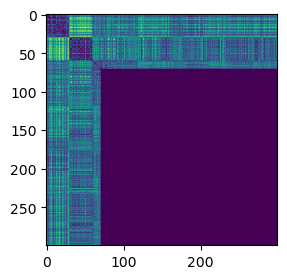

5.1000000000000005
1.9800000000000002
18.039999999999992
19.029999999999983
7.0699999999999985
5.020000000000001
11.009999999999987
3.0500000000000007
12.039999999999994
14.149999999999993
13.029999999999996
7.049999999999998
17.05999999999999
19.059999999999988
10.079999999999995
19.119999999999987
9.029999999999998
17.059999999999985
16.02999999999999
15.029999999999994
19.039999999999985
13.119999999999997
13.069999999999993
21.02999999999999
15.009999999999993
18.01999999999999
19.999999999999993
28.00999999999999
21.00999999999999
12.039999999999996
19.07999999999999
12.069999999999997
14.039999999999996
21.99999999999999
16.05999999999999
14.029999999999992
10.04
16.029999999999998
12.059999999999997
14.019999999999998
10.049999999999999
11.049999999999995
30.99999999999999
13.03999999999999
7.099999999999996
9.039999999999997
17.04999999999999
15.03999999999999
26.009999999999984
18.039999999999992
17.079999999999995
23.04999999999999
23.019999999999996
21.98999999999999
19.0299

24.99999999999999
17.11999999999999
22.019999999999992
28.019999999999992
29.079999999999984
22.069999999999993
16.069999999999997
25.01999999999999
20.08999999999999
23.06999999999999
27.039999999999985
22.039999999999992
23.07999999999999
32.00999999999999
20.009999999999987
16.039999999999992
2.0500000000000003
3.000000000000001
8.04
3.070000000000001
8.009999999999996
10.149999999999997
12.009999999999991
4.040000000000001
16.07999999999999
19.009999999999984
12.119999999999996
15.09999999999999
8.01
16.069999999999986
13.009999999999994
11.999999999999996
17.999999999999993
11.12
11.099999999999998
19.02999999999999
12.999999999999998
17.019999999999996
18.98999999999999
29.049999999999983
19.99999999999999
10.019999999999998
17.099999999999994
11.039999999999997
11.019999999999996
19.989999999999995
15.059999999999992
12.029999999999994
11.059999999999997
17.029999999999994
10.02
14.039999999999992
11.009999999999996
9.04
25.999999999999982
12.039999999999996
9.059999999999997
11

20.049999999999986
16.06999999999999
19.03999999999999
23.029999999999983
10.079999999999998
20.03999999999999
22.029999999999987
30.999999999999986
14.079999999999993
14.089999999999993
23.03999999999998
16.05999999999999
13.079999999999993
22.999999999999986
17.079999999999995
16.01999999999999
25.989999999999988
13.069999999999993
20.02999999999999
8.999999999999998
19.00999999999999
17.07999999999999
25.069999999999983
20.01999999999999
7.020000000000001
29.04999999999998
12.989999999999995
13.979999999999993
24.079999999999984
21.059999999999985
24.009999999999984
15.069999999999988
5.050000000000001
15.039999999999992
20.119999999999983
15.999999999999993
11.979999999999997
10.059999999999995
7.999999999999995
8.0
17.01999999999999
10.009999999999998
13.059999999999995
30.079999999999977
6.010000000000002
17.01999999999999
8.999999999999998
16.06999999999999
17.01999999999999
22.049999999999986
19.049999999999986
10.02
19.049999999999983
18.98999999999999
12.059999999999992
20.02

21.03999999999999
18.069999999999993
22.049999999999983
22.05999999999998
22.029999999999987
18.05999999999999
24.019999999999985
23.029999999999987
21.099999999999987
20.039999999999985
22.049999999999986
21.02999999999999
22.039999999999985
22.049999999999986
20.049999999999986
19.04999999999999
30.079999999999977
9.019999999999998
7.059999999999997
17.019999999999985
28.17999999999998
22.00999999999998
7.049999999999999
26.039999999999974
12.029999999999996
12.059999999999993
25.099999999999977
18.01999999999999
27.039999999999974
16.059999999999988
14.979999999999993
21.019999999999992
14.109999999999996
11.079999999999998
18.049999999999994
15.019999999999992
18.019999999999992
14.039999999999996
26.01999999999999
18.01999999999999
17.069999999999993
22.07999999999999
16.039999999999992
19.059999999999988
20.01999999999999
17.129999999999992
18.07999999999999
18.039999999999985
27.049999999999986
12.069999999999993
21.059999999999988
22.019999999999985
16.069999999999986
26.049999

17.989999999999988
26.98999999999998
20.019999999999985
23.029999999999987
18.019999999999992
30.99999999999998
21.00999999999999
20.99999999999999
23.999999999999986
20.99999999999999
20.019999999999992
22.969999999999988
18.029999999999987
20.02999999999999
19.999999999999986
24.04999999999999
9.07
23.109999999999985
11.02
8.059999999999999
14.069999999999993
17.97999999999999
9.009999999999998
17.08999999999999
7.049999999999998
14.07999999999999
16.099999999999994
16.98999999999999
24.009999999999984
17.159999999999993
15.009999999999993
18.999999999999993
16.019999999999992
21.989999999999984
22.039999999999992
29.989999999999988
20.00999999999999
15.039999999999996
20.109999999999996
12.989999999999998
16.04999999999999
20.989999999999988
23.019999999999992
15.049999999999988
13.099999999999996
15.099999999999994
17.039999999999992
13.079999999999997
10.029999999999998
15.059999999999992
28.979999999999983
16.049999999999994
15.129999999999994
13.039999999999994
20.01999999999999

23.07999999999999
32.009999999999984
29.04999999999999
24.06999999999999
27.01999999999999
25.04999999999999
24.039999999999985
24.069999999999986
12.09999999999999
23.07999999999999
24.05999999999999
22.099999999999987


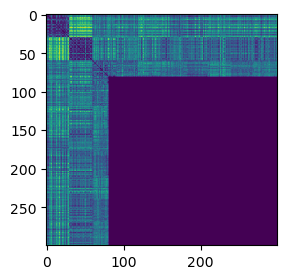

18.029999999999998
13.109999999999992
15.039999999999996
27.06999999999998
37.089999999999975
16.02999999999999
13.029999999999996
15.009999999999994
20.079999999999984
26.049999999999983
21.079999999999984
17.049999999999986
32.09999999999998
30.089999999999986
24.069999999999983
23.129999999999985
32.06999999999998
33.049999999999976
29.059999999999985
15.05999999999999
13.149999999999991
21.169999999999987
15.069999999999995
27.099999999999987
15.109999999999992
19.039999999999985
14.089999999999996
19.02999999999999
18.05999999999999
18.03999999999999
15.09999999999999
16.09999999999999
32.04999999999998
15.069999999999993
15.069999999999991
30.099999999999973
25.099999999999984
16.089999999999993
31.06999999999998
33.00999999999997
29.089999999999982
40.049999999999976
35.02999999999997
31.049999999999986
31.089999999999982
32.02999999999997
26.029999999999987
34.02999999999997
32.049999999999976
34.019999999999975
31.059999999999977
33.99999999999998
34.99999999999998
39.03999999

12.989999999999997
13.069999999999997
10.039999999999997
10.989999999999997
19.059999999999995
13.989999999999997
15.019999629191167
27.079999999999988
8.999999999999996
17.00999999999999
13.989999999999995
15.059999999999995
20.01999999999999
20.01999999999999
22.999999999999986
5.01
23.019999999999982
16.99999999999999
13.039999999999994
17.049999999999994
16.98999999999999
12.039999999999996
14.029999999999989
14.039999999999992
17.029999999999994
32.989999999999974
25.019999999999982
22.039999999999985
19.07999999999999
20.99999999999999
20.049999999999986
33.019999999999975
25.00999999999998
27.009999999999984
33.979999999999976
19.049999999999986
30.01999999999998
23.99999999999998
27.97999999999998
21.989999999999984
20.039999999999992
18.00999999999999
23.97999999999998
24.009999999999984
20.999999999999986
23.989999999999984
21.999999992796976
23.039999999999985
26.009999999999984
28.009999999999977
22.97999999999999
31.00999999999998
27.009999999999977
26.019999999999975
11.0

21.069999999999986
28.04999999999998
18.969999999999985
26.03999999999998
24.029999999999983
14.05999999999999
22.999999999999986
13.069999999999993
12.059999999999995
21.979999999999986
7.989999999999999
15.069999999999993
28.97999999999998
19.039999999999985
21.029999999999976
17.99999999999999
21.01999999999999
21.99999999999999
27.02999999999998
21.03999999999999
18.989999999999988
24.989999999999988
16.999999999999993
20.99999999999999
18.05999999999998
19.069999999999986
16.00999999999999
19.99999999999999
13.999999999999993
22.029999999999987
26.049999999999983
17.009999999999994
24.979999999999986
17.04999999999999
28.02999999999998
16.019999999999992
21.01999999999999
16.059999999999988
25.989999999999984
18.029999999999987
15.079999999999993
11.039999999999996
21.989999999999988
18.059999999999988
13.019999999999994
12.019999999999994
19.00999999999999
11.999999999999998
16.999999999999993
8.019999999999996
12.999999999999996
16.019999999999992
14.009999999999991
11.009999999

24.049999999999983
17.02999999999999
22.059999999999985
17.029999999999994
20.049999999999986
20.029999999999987
20.05999999999999
21.019999999999992
21.05999999999999
23.009999999999987
17.069999999999993
19.039999999999992
24.07999999999999
22.069999999999983
26.059999999999977
21.089999999999982
20.039999999999985
22.079999999999977
27.08999999999998
24.099999999999984
17.08999999999999
21.07999999999998
29.039999999999974
18.069999999999983
21.069999999999993
20.07999999999998
17.079999999999988
27.08999999999998
20.079999999999984
23.039999999999985
21.079999999999984
14.049999999999992
20.03999999999998
20.049999999999986
27.099999999999977
22.07999999999998
27.049999999999983
27.099999999999984
17.049999999999994
23.069999999999983
21.089999999999982
24.039999999999985
20.06999999999999
14.039999999999992
26.079999999999984
22.049999999999986
26.009999999999984
21.019999999999985
22.01999999999999
21.02999999999998
20.08999999999999
16.079999999999995
18.98999999999999
20.039999

15.049999999999994
16.06999999999998
22.059999999999985
13.029999999999983
21.079999999999984
15.079999999999991
16.039999999999992
23.079999999999977
17.069999999999983
25.07999999999999
16.10999999999999
15.06999999999999
17.089999999999982
14.059999999999992
28.10999999999998
16.119999999999987
26.05999999999998
30.079999999999977
13.049999999999992
21.05999999999998
17.06999999999999
25.009999999999987
16.07999999999999
10.029999999999998
23.069999999999986
19.04999999999999
23.969999999999985
17.009999999999987
16.109999999999992
16.039999999999985
14.079999999999997
12.039999999999992
13.019999999999992
14.039999999999992
20.999999999999982
17.03999999999999
18.059999999999985
17.00999999999999
14.019999999999992
13.019999999999996
16.99999999999999
25.059999999999985
18.999999999999986
16.03999999999999
11.029999999999994
17.009999999999998
17.08999999999999
18.04999999999999
12.99999999999999
18.01999999999999
20.019999999999982
11.049999999999997
16.009999999999984
21.07999999

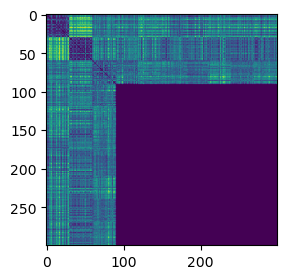

6.02
8.109999999999998
16.979999999999997
8.039999999999997
4.979999999999998
5.030000000000001
2.9800000000000004
16.069999999999993
3.9900000000000007
5.020000000000001
14.129999999999988
3.0100000000000002
8.0
7.009999999999999
7.100000000000001
8.009999999999996
10.999999999999993
9.02
6.000000000000001
11.009999999999993
7.999999999999997
5.010000000000002
16.019999999999992
7.000000000000001
4.07
14.999999999999991
7.03
6.999999999999998
35.00999999999998
19.039999999999978
27.06999999999998
13.049999999999994
11.029999999999996
18.05999999999999
42.999999999999986
13.999999999999996
23.029999999999983
24.02999999999998
20.029999999999987
16.029999999999983
23.989999999999984
16.019999999999982
15.019999999999984
15.009999999999993
14.979999999999992
18.01999999999999
25.079999999999984
15.059999999999985
21.089999999999986
18.009999999999987
30.089999999999982
22.019999999999975
22.009999999999977
14.019999999999992
22.979999999999986
23.989999999999977
21.019999999999982
11.029

27.09999999999998
24.04999999999999
24.109999999999985
25.03999999999999
30.05999999999998
28.04999999999999
32.07999999999998
27.09999999999998
27.079999999999984
21.059999999999988
29.06999999999998
27.079999999999984
28.07999999999998
7.119999999999999
31.099999999999977
21.10999999999999
14.11999999999999
25.089999999999975
28.039999999999992
18.129999999999985
14.129999999999988
25.13999999999998
29.089999999999982
16.11999999999999
12.099999999999994
23.11999999999998
12.129999999999992
12.109999999999998
14.119999999999994
13.009999999999994
14.159999999999991
10.019999999999994
19.119999999999987
17.10999999999999
11.109999999999994
18.149999999999988
13.059999999999999
21.079999999999984
15.099999999999993
12.099999999999996
19.12999999999998
20.059999999999985
18.149999999999988
21.089999999999982
25.129999999999985
27.089999999999986
25.019999999999992
21.079999999999988
21.069999999999986
22.059999999999985
21.059999999999988
18.10999999999999
25.089999999999982
18.07999999

12.049999999999997
22.97999999999999
19.01999999999999
9.04
18.02999999999999
9.979999999999999
21.98999999999998
5.98
11.979999999999993
21.999999999999986
11.009999999999994
15.989999999999986
9.04
15.019999999999992
14.009999999999991
19.99999999999999
19.00999999999999
18.99999999999999
21.009999999999987
19.009999999999987
13.029999999999994
14.039999999999992
15.999999999999988
16.999999999999986
22.009999999999984
22.009999999999984
20.009999999999987
14.039999999999992
17.00999999999999
14.03999999999999
23.999999999999993
17.01999999999999
28.989999999999984
13.009999999999993
21.009999999999987
13.999999999999993
17.079999999999988
24.059999999999988
19.989999999999988
18.02999999999999
18.979999999999993
8.02
7.970000000000001
11.029999999999996
19.989999999999988
20.97999999999999
7.999999999999998
18.02999999999999
6.02
17.989999999999988
13.059999999999995
21.989999999999988
8.02
23.989999999999988
8.989999999999997
19.00999999999999
9.009999999999996
19.049999999999983
2

16.04999999999999
20.029999999999987
14.049999999999994
17.059999999999988
11.029999999999992
13.01999999999999
17.999999999999986
12.019999999999994
15.009999999999994
13.979999999999997
15.009999999999991
15.98999999999999
18.03999999999999
12.999999999999995
9.989999999999995
15.99999999999999
7.010000000000102
11.009999999999996
12.019999999999998
12.019999999999994
11.019999999999992
5.009999999999998
14.039999999999992
10.979999999999995
15.039999999999988
13.989999999999991
16.019999999999992
12.009999999999996
12.019999999999996
11.029999999999996
14.069999999999993
12.029999999999994
12.979999999999992
11.029999999999994
12.06999999999999
16.97999999999999
12.099999999999994
6.149999999999999
10.009999999999998
8.14
19.029999999999987
19.989999999999984
12.009999999999996
14.99999999999999
12.019999999999994
10.0
14.999999999999993
3.0500000000000003
15.019999999999994
11.999999999999995
5.050000000000001
15.989999999999988
17.999999992622946
14.019999999999994
10.999999999999

15.05999999999999
27.029999999999983
18.049999999999986
20.019999999999985
18.999999999999986
21.009999999999987
17.999999999999993
20.01999999999999
28.009999999999984
18.04999999999999
21.009999999999984
16.019999999999992
25.009999999999984
21.999999999999986
19.019999999999985
21.989999999999984
21.99999999999999
15.989999995554705
20.01999999999999
18.999999999999993
12.009999999999994
9.02
14.109999999999994
2.0000000000000004
11.029999999999996
2.0100000000000007
4.109999999999996
13.009999999999994
12.969999999999992
12.010000000000002
6.01
12.999999999999996
14.029999999999989
8.020000000000001
6.039999999999999
10.979999999999999
10.029999999999998
13.999999999999995
6.02
10.999999999999998
30.969999999999978
21.039999999999978
23.069999999999986
8.07
16.979999999999993
14.06999999999999
34.009999999999984
18.97999999999999
22.999999999999986
24.039999999999978
13.029999999999998
15.029999999999992
24.039999999999985
18.039999999999985
16.009999999999987
9.039999999999996
17.

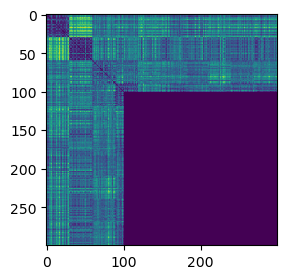

6.109999999999996
6.050000000000001
1.9900000000000004
11.019999999999998
7.050000000000001
1.9800000000000004
3.0300000000000002
3.0100000000000007
10.999999999999996
3.0000000000000004
3.0300000000000002
1.9900000000000004
25.029999999999987
1.9700000000000004
4.000000000000001
20.009999999999987
6.029999999999999
1.9800000000000004
29.039999999999978
16.039999999999992
27.079999999999977
16.089999999999993
16.049999999999994
19.03999999999999
34.02999999999999
15.019999999999994
20.059999999999985
18.04999999999999
18.029999999999998
14.049999999999992
21.989999999999988
14.059999999999992
17.039999999999992
19.059999999999988
24.04999999999999
19.07999999999999
23.049999999999983
15.059999999999995
19.07999999999999
18.00999999999999
28.05999999999998
23.009999999999984
18.01999999999999
14.099999999999994
18.00999999999999
18.059999999999985
17.029999999999994
18.01999999999999
6.039999999999997
20.08999999999999
12.069999999999991
10.039999999999996
16.02999999999999
21.019999999

12.009999999999994
10.029999999999996
10.969999999999997
13.089999999999993
9.02
8.08
10.999999999999998
11.969999999999992
10.139999999999997
12.999999999999993
18.019999999999992
11.029999999999992
15.029999999999987
8.009999999999998
14.01999999999999
4.980000000000001
8.999999999999996
17.009999999999984
12.009999999999996
15.019999999999989
10.999999999999996
14.02999999999999
11.999999999999996
15.009999999999991
14.999999999999991
13.029999999999989
20.01999999999999
15.019999999999992
13.989999999999993
16.01999999999999
13.019999999999992
13.989999999999995
18.009999999999987
14.019999999999989
15.979999999999986
17.009999999999987
13.029999999999994
15.019999999999985
18.029999999999987
18.009999999999984
24.98999999999998
6.979999999999999
17.009999999999987
10.989999999999998
17.059999999999988
21.019999999999982
12.029999999999992
12.009999999999996
10.979999999999997
12.009999999999996
10.039999999999997
12.009999999999996
11.019999999999998
12.009999999999993
9.999999999

9.009999999999998
19.02999999999999
13.99999999999999
16.029999999999994
19.97999999999999
27.009999999999984
12.039999999999992
5.029999999999999
18.999999999999993
14.989999999999993
16.999999999999993
17.999999999999993
15.009999999999993
18.97999999999999
5.020000000000001
22.999999999999986
8.029999999999998
12.049999999999988
22.97999999999999
20.019999999999992
16.01999999999999
10.979999999999995
16.019999999999992
18.03999999999999
18.96999999999999
11.019999999999994
10.079999999999995
14.039999999999997
21.989999999999984
10.049999999999997
10.089999999999995
14.009999999999991
12.049999999999992
27.979999999999986
11.049999999999999
14.969999999999992
17.97999999999999
20.00999999999999
11.02
10.049999999999995
3.030000000000001
11.069999999999993
12.999999999999995
10.019999999999998
17.029999999999998
9.03
6.03
11.039999999999996
12.969999999999995
8.039999999999994
8.01
16.019999999999992
5.000000000000002
15.039999999999987
9.999999999999996
9.040000000000001
12.0299999

24.009999999999987
19.04999999999999
25.01999999999999
19.039999999999992
19.01999999999999
18.059999999999988
17.009999999999994
14.029999999999994
22.039999999999985
15.06999999999999
20.009999999999994
20.019999999999992
27.979999999999983
21.009999999999987
21.029999999999987
15.059999999999995
17.039999999999992
21.009999999999987
20.04999999999999
24.019999999999985
21.009999999999987
19.01999999999999
14.999999999999995
18.059999999999988
19.01999999999999
22.999999999999986
7.049999999999999
22.999999999999993
14.059999999999985
12.079999999999995
18.069999999999986
21.989999999999988
19.019999999999985
12.989999999999995
20.079999999999988
22.999999999999993
12.099999999999998
9.019999999999996
17.079999999999984
8.079999999999995
14.009999999999996
9.039999999999997
12.099999999999994
8.120000000000001
9.089999999999993
12.059999999999993
16.009999999999984
8.06
14.06999999999999
13.039999999999994
13.069999999999993
15.039999999999994
8.999999999999995
9.119999999999997
16.0

10.999999999999996
17.99999999999999
13.039999999999996
13.049999999999994
16.05999999999999
17.039999999999985
17.01999999999999
16.03999999999999
15.999999999999986
18.98999999999999
21.069999999999986
16.039999999999985
25.98999999999998
24.969999999999985
13.039999999999996
17.04999999999999
18.019999999999985
25.999999999999982
28.98999999999998
14.019999999999996
25.999999999999982
18.01999999999999
26.009999999999977
21.99999999999999
25.019999999999992
14.049999999999994
28.009999999999977
16.039999999999992
24.989999999999984
11.009999999999994
23.02999999999998
28.989999999999984
17.979999999999986
16.069999999999993
13.02
22.009999999999984
19.999999999999986
19.03999999999999
11.049999999999997
18.049999999999994
13.019999999999996
21.00999999999999
22.009999999999987
25.049999999999983
14.029999999999987
10.02
19.00999999999999
14.029999999999994
18.03999999999999
21.02999999999998
15.029999999999987
16.00999999999999
8.05
20.039999999999992
12.049999999999997
15.009999999

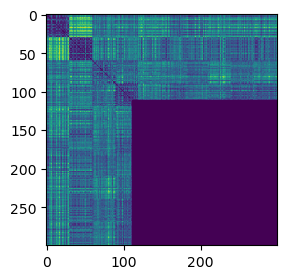

2.0200000000000005
3.0200000000000005
28.009999999999987
4.020000000000001
8.02
20.989999999999988
16.99999999999999
3.0500000000000007
32.01999999999998
15.069999999999991
29.019999999999982
19.089999999999996
21.019999999999985
23.01999999999999
31.01999999999999
17.029999999999987
20.999999999999986
17.05999999999999
22.989999999999988
12.069999999999993
21.039999999999992
15.059999999999992
18.049999999999994
17.049999999999994
25.999999999999986
20.04999999999999
23.999999999999993
15.089999999999998
21.07999999999999
21.999999999999986
28.049999999999986
25.999999999999986
19.039999999999985
19.039999999999985
17.01999999999999
18.05999999999999
18.04999999999999
22.989999999999984
6.0299999999999985
21.059999999999988
11.079999999999998
8.079999999999998
15.079999999999993
19.01999999999999
16.03999999999999
13.009999999999996
17.08999999999999
20.059999999999995
8.099999999999998
12.019999999999992
15.09999999999999
8.059999999999995
7.049999999999999
10.039999999999994
16.0699

15.029999999999992
17.009999999999994
21.029999999999987
20.039999999999992
19.01999999999999
15.04999999999999
23.019999999999985
24.05999999999998
13.079999999999991
18.049999999999986
17.03999999999999
19.00999999999999
21.04999999999999
14.079999999999995
15.05999999999999
19.03999999999999
24.019999999999985
17.069999999999986
20.009999999999994
18.039999999999985
18.01999999999999
19.059999999999995
22.019999999999982
15.089999999999998
22.99999999999999
17.04999999999999
19.059999999999988
14.119999999999992
18.03999999999999
12.099999999999998
36.00999999999998
9.069999999999997
20.98999999999998
20.01999999999999
28.019999999999985
23.029999999999987
23.049999999999986
17.02999999999999
12.079999999999995
19.039999999999992
10.08
17.04999999999999
19.04999999999999
14.079999999999993
12.049999999999997
11.999999999999995
6.05
11.019999999999998
6.989999999999999
6.0600000000000005
11.03
7.039999999999998
7.0600000000000005
8.059999999999999
12.039999999999996
10.03
13.08999999

14.089999999999991
10.019999999999998
14.049999999999994
23.99999999999999
19.989999999999988
14.029999999999994
14.079999999999993
19.99999999999999
18.00999999999999
14.049999999999994
17.019999999999992
22.989999999999984
21.009999999999987
15.059999999999995
9.029999999999998
19.019999999999996
12.069999999999997
14.069999999999993
25.99999999999999
12.059999999999995
17.01999999999999
28.98999999999998
20.029999999999987
9.059999999999997
8.0
29.01999999999998
24.089999999999982
26.01999999999998
26.049999999999983
23.03999999999999
22.019999999999985
27.02999999999999
26.019999999999985
21.079999999999984
29.069999999999983
24.05999999999999
22.089999999999993
26.07999999999998
23.089999999999982
23.079999999999984
25.059999999999985
19.099999999999987
29.109999999999978
21.029999999999987
28.03999999999998
24.999999999999986
26.049999999999983
22.00999999999999
29.099999999999984
23.079999999999984
25.069999999999983
18.059999999999988
22.09999999999998
23.06999999999998
18.0899

8.01
13.019999999999996
6.979999999999997
9.059999999999995
9.039999999999996
6.060000000000001
12.039999999999996
6.109999999999997
10.039999999999997
17.989999999999988
15.00999999999999
8.05
6.030000000000001
11.069999999999993
6.010000000000001
12.009999999999991
11.009999999999998
6.0600000000000005
13.009999999999998
10.049999999999995
16.029999999999994
11.009999999999998
11.029999999999996
11.069999999999997
10.039999999999992
18.04999999999999
7.03
12.049999999999994
11.07
14.039999999999992
16.049999999999997
11.019999999999996
12.97999999999999
18.97999999999999
16.01999999999999
13.049999999999995
17.009999999999994
19.97999999999999
21.999999999999982
20.01999999999999
17.039999999999985
17.979999999999986
18.98999999999999
21.029999999999983
18.01999999999999
20.039999999999992
14.009999999999993
17.99999999999999
20.01999999999999
19.04999999999999
19.97999999999999
15.05999999999999
18.039999999999985
19.039999999999985
15.029999999999987
18.999999999999982
18.029999999

27.98999999999998
29.999999999999986
28.029999999999987
23.999999999999982
28.989999999999984
18.999999999999993
22.00999999999999
24.009999999999984
29.009999999999984
16.969999999999988
18.009999999999987
25.009999999999987
26.999999999999982
14.019999999999994
19.029999999999987
22.00999999999999
17.01999999999999
18.01999999999999
22.049999999999983
25.01999999999999
26.00999999999999
16.04999999999999
26.00999999999998
24.01999999999999
16.009999999999994
23.019999999999982
21.009999999999987
14.009999999999987


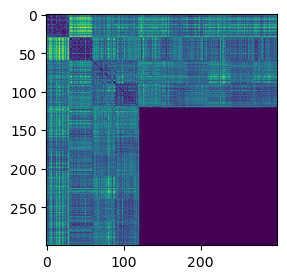

21.03999999999999
10.990000000000002
7.989999999999998
20.049999999999983
20.049999999999983
2.0400000000000005
9.089999999999996
2.0100000000000007
13.989999999999991
1.9800000000000002
1.9900000000000002
2.0200000000000005
2.0300000000000002
6.010000000000001
15.039999999999987
2.0200000000000005
22.049999999999983
2.0100000000000007
16.02999999999999
5.9799999999999995
22.999999999999986
10.969999999999994
1.9700000000000002
3.990000000000001
8.069999999999995
4.000000000000001
2.0000000000000004
11.999999999999996
16.039999999999992
7.029999999999999
9.019999999999998
7.9999999999999964
9.009999999999996
15.049999999999995
15.019999999999985
14.049999999999992
7.989999999999996
11.009999999999996
6.990000000000001
23.01999999999998
6.990000000000001
9.069999999999999
15.049999999999992
11.069999999999997
20.109999999999992
7.029999999999995
22.029999999999987
11.029999999999998
17.039999999999985
28.03999999999998
9.999999999999995
26.079999999999988
25.029999999999983
9.1099999999

11.009999999999998
10.0
17.009999999999998
13.979999999999995
15.989999999999995
7.04
19.029999999999994
14.049999999999995
13.04
14.019999999999994
11.069999999999995
5.98
14.089999999999987
11.03
11.999999999999996
8.06
9.009999999999998
10.06
9.019999999999998
9.03
15.009999999999996
25.019999999999985
14.039999999999997
8.039999999999996
15.069999999999997
16.009999999999994
13.019999999999992
14.039999999999992
12.039999999999996
17.989999999999988
11.999999999999996
19.009999999999987
7.050000000000001
14.069999999999995
17.039999999999992
15.019999999999992
16.05999999999999
8.039999999999997
16.049999999999994
21.069999999999993
13.989999999999995
8.029999999999998
14.079999999999991
19.07999999999999
19.999999999999986
15.079999999999991
18.089999999999993
16.97999999999999
20.08999999999999
20.029999999999994
4.0600000000000005
8.0
7.99
11.009999999999994
5.98
7.0600000000000005
10.01
6.129999999999998
5.000000000000001
22.009999999999987
10.059999999999999
9.08
5.06000000000

28.049999999999983
28.97999999999998
30.009999999999987
28.06999999999998
30.02999999999998
28.02999999999998
46.97999999999998
26.029999999999983
28.02999999999998
24.029999999999983
33.01999999999998
27.02999999999998
36.02999999999997
28.039999999999985
26.99999999999998
27.029999999999987
29.979999999999983
30.999999999999982
28.019999999999985
21.039999999999985
35.03999999999998
31.04999999999998
23.07999999999998
31.03999999999998
28.039999999999978
32.00999999999998
26.009999999999984
30.02999999999998
28.999999999999982
29.98999999999998
24.039999999999985
22.039999999999985
29.079999999999984
28.03999999999998
26.019999999999985
36.00999999999998
33.99999999999998
25.009999999999984
28.019999999999982
31.05999999999998
26.009999999999987
28.99999999999998
23.049999999999983
20.079999999999984
16.059999999999988
13.019999999999994
33.99999999999998
21.049999999999983
30.999999999999986
33.049999999999976
18.029999999999987
31.99999999999998
20.079999999999995
25.04999999999998

18.109999999999992
14.039999999999985
26.08999999999999
14.149999999999995
24.06999999999999
23.06999999999999
12.109999999999996
20.97999999999999
11.019999999999996
16.08999999999999
11.029999999999996
13.119999999999996
13.03999999999999
11.079999999999993
20.069999999999986
23.069999999999986
11.069999999999995
12.999999999999991
17.07999999999999
13.04999999999999
12.04999999999999
20.999999999999986
14.069999999999997
18.089999999999993
14.02999999999999
12.099999999999994
15.049999999999994
13.069999999999993
16.05999999999999
17.069999999999986
18.039999999999985
12.979999999999997
2.0000000000000004
2.0100000000000002
2.980000000000001
3.0100000000000007
8.019999999999998
15.999999999999991
4.040000000000001
17.079999999999988
3.0100000000000007
13.979999999999997
7.0
19.99999999999999
8.97
3.98
7.000000000000001
7.099999999999998
4.98
4.0
15.009999999999991
19.049999999999986
13.019999999999996
13.049999999999995
8.009999999999994
12.029999999999996
18.999999999999996
19.0099

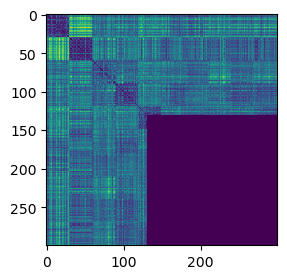

4.0200000000000005
2.0200000000000005
4.000000000000001
4.020000000000001
15.019999999999989
5.02
18.089999999999993
2.0100000000000007
11.069999999999997
4.98
23.069999999999993
7.0
1.9800000000000004
3.010000000000001
3.0800000000000005
5.989999999999999
2.0000000000000004
11.979999999999997
15.039999999999992
14.089999999999993
10.039999999999997
7.019999999999999
11.029999999999996
17.979999999999993
14.989999999999991
16.04999999999999
11.009999999999996
15.01999999999999
9.01
20.019999999999985
10.009999999999996
6.999999999999998
12.029999999999996
11.999999999999996
16.099999999999987
8.01
21.059999999999985
12.999999999999995
19.019999999999985
24.06999999999998
12.019999999999994
23.05999999999999
21.01999999999999
8.119999999999997
12.049999999999994
6.999999999999999
16.009999999999987
8.999999999999993
13.01999999999999
13.999999999999996
15.999999999999991
18.03999999999999
10.049999999999995
14.029999999999998
13.029999999999992
15.999999999999991
11.999999999999996
16.0

14.009999999999993
14.029999999999994
13.019999999999992
13.999999999999993
17.00999999999999
17.029999999999994
12.999999999999993
13.989999999999991
18.009999999999998
15.019999999999989
23.009999999999984
10.069999999999997
12.979999999999999
7.099999999999995
5.049999999999997
8.029999999999994
8.049999999999995
5.009999999999999
22.98999999999999
4.040000000000001
5.0200000000000005
19.039999999999992
3.000000000000001
14.979999999999995
9.989999999999998
7.079999999999997
7.0699999999999985
11.029999999999998
12.009999999999998
4.030000000000001
13.969999999999994
10.03
15.989999999999993
5.030000000000002
5.020000000000001
12.019999999999998
8.009999999999998
7.009999999999998
17.00999999999999
7.999999999999996
5.050000000000001
16.009999999999994
4.0600000000000005
6.020000000000001
2.0000000000000004
16.039999999999992
3.0300000000000007
9.99
4.04
23.00999999999999
5.999999999999999
3.010000000000001
3.060000000000001
9.059999999999995
6.000000000000001
3.0800000000000005
8.0

20.04999999999999
14.999999999999993
18.00999999999999
17.049999999999986
14.01999999999999
16.98999999999999
19.99999999999999
16.029999999999994
14.989999999999995
19.99999999999999
16.009999999999994
12.049999999999994
19.029999999999987
21.98999999999999
16.999999999999993
16.98999999999999
15.97999999999999
16.979999999999993
20.99999999999999
21.999999999999982
12.989999999999991
20.08999999999999
18.969999999999988
16.969999999999988
18.97999999999999
10.979999999999997
17.039999999999992
17.009999999999994
17.99999999999999
10.969999999999995
14.04999999999999
22.119999999999987
19.989999999999984
11.039999999999994
17.109999999999992
10.999999999999996
22.049999999999983
21.97999999999999
8.01
12.999999999999995
11.989999999999995
16.979999999999986
10.969999999999997
9.02
16.98999999999999
13.019999999999989
7.02
18.009999999999987
10.989999999999993
16.009999999999994
8.989999999999993
10.969999999999995
9.999999999999996
13.03999999999999
10.019999999999994
11.0099999999999

15.069999999999984
14.059999999999986
19.109999999999985
8.989999999999995
11.069999999999991
8.989999999999998
16.11999999999999
12.089999999999991
10.019999999999998
7.01
8.989999999999997
11.969999999999994
8.98
14.059999999999992
10.009999999999998
8.999999999999998
14.009999999999991
11.999999999999995
6.99
10.04
8.989999999999998
13.999999999999998
14.989999999999993
10.979999999999997
4.99
22.00999999999999
10.039999999999996
11.049999999999992
11.019999999999992
17.049999999999986
10.999999999999993
19.08999999999999
8.029999999999998
11.009999999999993
10.039999999999996
8.979999999999995
10.059999999999997
11.979999999999997
8.04
8.009999999999998
14.009999999999996
8.029999999999998
7.029999999999998
10.069999999999999
10.999999999999996
9.02
8.03
7.050000000000001
12.999999999999995
14.989999999999993
14.009999999999991
6.039999999999999
14.069999999999999
9.989999999999997
7.03
11.059999999999997
7.019999999999998
10.009999999999998
12.069999999999999
8.999999999999998
8.0

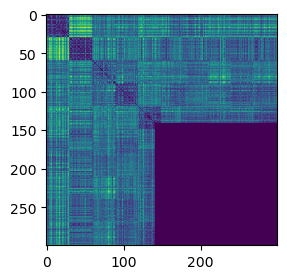

17.109999999999992
2.9700000000000006
2.0100000000000007
1.9700000000000002
8.049999999999999
2.0200000000000005
1.9800000000000004
9.999999999999993
23.99999999999999
17.969999999999988
16.029999999999994
15.979999999999993
14.009999999999996
8.999999993333324
19.989999999999984
16.099999999999987
12.009999999999994
15.98999999999999
13.989999999999991
20.029999999999994
11.979999999999995
14.999999999999991
20.01999999999999
17.989999999999995
19.109999999999978
12.989999999999995
24.03999999999998
16.009999999999994
17.03999999999999
26.029999999999976
15.999999999999996
28.109999999999985
21.039999999999985
12.119999999999992
17.02999999999999
12.019999999999994
13.979999999999986
11.989999999999997
9.019999999999996
10.999999999999996
12.989999999999991
9.069999999999993
10.079999999999995
8.07
8.069999999999997
10.009999999999998
11.039999999999992
9.069999999999997
11.079999999999995
11.069999999999995
13.009999999999991
8.04
9.0
8.039999999999996
10.059999999999997
11.059999999

19.069999999999986
10.979999999999995
10.020000000000001
7.979999999999997
14.009999999999991
11.079999999999991
7.019999999999998
7.0299999999999985
10.01
8.019999999999998
9.009999999999998
12.02999999999999
9.010000000000002
13.049999999999997
7.010000000000001
8.029999999999994
5.049999999999997
10.959999999999999
6.050000000000001
9.999999999999993
11.989999999999997
2.0100000000000007
5.0600000000000005
1.9800000000000004
1.9900000000000004
12.01999999999999
23.019999999999982
13.999999999999993
14.049999999999994
11.999999999999996
10.999999999999998
15.97999999999999
21.999999999999982
16.049999999999994
11.999999999999993
14.999999999999988
9.999999999999996
22.03999999999999
10.999999999999996
9.079999999999998
17.049999999999986
13.02999999999999
18.089999999999986
9.009999999999998
27.019999999999985
13.029999999999994
20.999999999999982
28.029999999999987
10.069999999999999
27.079999999999984
23.02999999999998
11.079999999999997
18.059999999999988
8.019999999999998
19.9999

16.09999999999998
15.079999999999993
16.119999999999994
12.079999999999991
7.049999999999999
18.01999999999999
3.000000000000001
9.099999999999994
14.05999999999999
11.049999999999994
14.009999999999998
8.029999999999996
14.069999999999988
13.089999999999993
3.080000000000001
7.050000000000002
9.040000000000001
8.079999999999998
5.039999999999997
12.019999999999992
7.05
10.059999999999995
9.019999999999994
10.049999999999992
8.079999999999997
18.979999999999993
9.079999999999991
10.099999999999994
17.019999999999996
2.0000000000000004
13.039999999999988
25.999999999999982
13.099999999999993
12.029999999999994
12.009999999999998
11.009999999999994
13.979999999999993
26.999999999999975
17.039999999999992
10.999999999999993
15.009999999999991
9.019999999999998
21.03999999999999
8.03
10.059999999999997
19.00999999999999
12.029999999999996
18.089999999999993
9.039999999999994
24.019999999999985
12.049999999999992
21.979999999999983
25.109999999999978
11.059999999999993
29.029999999999983
27

8.989999999999998
11.999999999999993
6.01
14.119999999999994
10.019999999999998
8.059999999999999
4.0600000000000005
6.029999999999998
6.029999999999999
10.009999999999994
5.030000000000001
11.979999999999997
4.050000000000001
14.019999999999994
7.040000000000002
6.03
11.029999999999998
7.009999999999997
4.0200000000000005
3.99
13.989999999999997
4.000000000000001
4.010000000000001
15.009999999999998
20.029999999999987
10.04
7.040000000000001
22.00999999999998
15.04
9.999999999999995
9.03
19.029999999999987
20.019999999999992
11.999999999999996
8.03
17.029999999999987
9.999999999999996
3.0100000000000007
11.009999999999998
11.129999999999994
9.979999999999999
4.050000000000001
12.029999999999998
13.989999999999993
10.109999999999996
14.009999999999998
18.019999999999992
16.08999999999999
12.039999999999997
3.0000000000000004
11.03
9.979999999999999
6.070000000000002
16.01999999999999
15.01999999999999
19.019999999999985
15.019999999999994
17.99999999999999
15.989999999999995
14.9799999

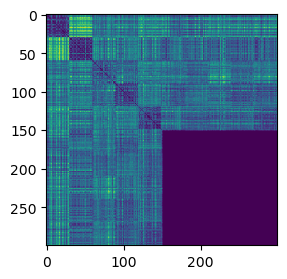

4.0200000000000005
4.130000000000001
2.0100000000000007
13.009999999999996
18.999999999999986
23.999999999999986
2.0600000000000005
2.0000000000000004
4.07
29.969999999999985
3.0300000000000007
13.089999999999995
10.08
12.049999999999995
38.03999999999998
10.049999999999997
26.019999999999982
15.02999999999999
25.99999999999998
33.989999999999974
6.029999999999998
27.079999999999984
35.95999999999997
20.049999999999986
23.98999999999998
9.009999999999994
22.009999999999984
14.989999999999995
24.03999999999998
20.979999999999983
22.969999999999985
24.009999999999984
23.03999999999998
21.00999999999999
21.029999999999983
18.029999999999983
20.049999999999983
28.979999999999983
23.02999999999998
26.989999999999977
25.02999999999998
19.049999999999983
22.029999999999987
24.019999999999982
21.049999999999986
24.01999999999999
28.979999999999983
21.999999999999986
22.98999999999998
29.02999999999998
28.98999999999998
34.019999999999975
8.019999999999996
23.03999999999998
15.999999999999995
3

11.089999999999995
7.059999999999999
8.039999999999997
33.04999999999998
7.039999999999997
29.019999999999982
11.019999999999994
24.99999999999998
30.009999999999977
4.010000000000001
25.07999999999998
29.98999999999998
19.06999999999999
24.019999999999982
6.009999999999998
21.999999999999986
14.999999999999991
21.00999999999998
20.999999999999986
24.979999999999976
25.029999999999987
23.009999999999984
23.98999999999998
19.989999999999988
15.98999999999999
14.979999999999988
26.97999999999998
21.009999999999984
27.00999999999998
29.02999999999998
18.009999999999984
21.019999999999982
24.979999999999983
22.029999999999983
25.979999999999983
26.969999999999985
19.979999999999983
18.00999999999999
25.02999999999998
26.989999999999988
30.999999999999975
8.049999999999994
21.999999999999982
18.019999999999992
31.04999999999998
21.039999999999985
20.019999999999982
13.029999999999996
5.010000000000001
23.97999999999998
17.989999999999988
22.039999999999992
8.04
8.04
24.009999999999984
12.03

In [ ]:
data_matrix = torch.zeros(batch_size, batch_size)

for i in range(len(dataset[1])):
    im1 = (dataset[0][i, 0] > thresh).float() * 1
    
    for j in range(i + 1, len(dataset[1])):
        im2 = (dataset[0][j, 0] > thresh).float() * 1
        image_diff = model.get_similarity_score(im1, im2, False)
        print(image_diff, flush=True)
        data_matrix[i, j] = image_diff
        data_matrix[j, i] = image_diff
        
    if i % 10 == 0:
        plt.figure(figsize=[3, 3])
        plt.imshow(data_matrix)
        plt.show()
        
plt.imshow(data_matrix)
plt.savefig("optimization_similarity_matrix")
plt.show()

# Visualizing Shifts

In [ ]:
test_img1 = dataset[0][76, 0]
plt.figure(figsize=[1, 1])
plt.imshow(test_img1)
plt.show()

for x in range(3):
    for y in range(3):
        test_img2 = torch.zeros(test_img1.shape)
        test_img2[y:test_img2.shape[0]+y-2, x:test_img2.shape[1]+x-2] = test_img1[1:-1, 1:-1]
        
        plt.figure(figsize=[1, 1])
        plt.imshow(test_img2)
        plt.show()

        image_diff = model.get_similarity(test_img2, test_img1)

        shift_vals = model.m.getVars()

        plt.imshow(test_img2)
        for val in shift_vals:
            if val.X == 1:
                index = find_between(val.VarName, "[", "]").split(",")
                if len(index) != 4:
                    continue
                if test_img2[int(index[0]), int(index[1])] > 0:
                    if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                        plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
                    else:
                        plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
        plt.savefig(f"shifted_img_{x}_{y}")
        plt.show()